# Personalized Medicine: Redefining Cancer Treatment

# Установка и импорт пакетов

In [1]:
import re
import time
import nltk
import math
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from datetime import datetime
from collections import Counter, defaultdict
from scipy.sparse import hstack
from nltk.corpus import stopwords
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

warnings.filterwarnings("ignore");
nltk.download('stopwords');

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# 1. Бизнес проблема
## 1.1. Описание

- **Data**: https://www.kaggle.com/c/msk-redefining-cancer-treatment/
- **Source**: Memorial Sloan Kettering Cancer Center (MSKCC)
- **Problem statement**: Classify the given genetic variations/mutations based on evidence from text-based clinical literature.

## 1.2. Полезные ссылки
-  Some articles and reference blogs about the problem statement

1. https://www.forbes.com/sites/matthewherper/2017/06/03/a-new-cancer-drug-helped-almost-everyone-who-took-it-almost-heres-what-it-teaches-us/#2a44ee2f6b25
2. https://www.youtube.com/watch?v=UwbuW7oK8rk
3. https://www.youtube.com/watch?v=qxXRKVompI8

## 1.3. Задачи и ограничения в бизнесе\реальной задаче
- Нет требований к низкой задержке.
- Важна интерпретируемость.
- Ошибки могут быть очень дорогостоящими.
- Необходима вероятность принадлежности точки данных к каждому классу.

# 2. Machine Learning Problem Formulation
## 2.1. Data
### 2.1.1. Data Overview

- У нас есть два файла данных: один содержит информацию о генетических мутациях, а другой - клинические данные (текст), которые человеческие эксперты/патологи используют для классификации генетических мутаций.
- Оба этих файла данных имеют общий столбец под названием ID
- Информация о файле данных:
training_variants (ID , Gene, Variations, Class)
training_text (ID, Текст)

Существует девять различных классов, к которым можно отнести генетические мутации => Проблема классификации нескольких классов

Метрики:
- Мульти класс log-loss (нам нужны вероятности классов)
- Confusion матрица
    
### 2.1.2. Примеры данных
**training_variants**<br>
...................<br>
ID,Gene,Variation,Class<br>
0,FAM58A,Truncating Mutations,1 <br>
1,CBL,W802*,2 <br>
2,CBL,Q249E,2 <br>

<hr>

**training_text**<br>
...................<br>
ID,Text <br>
0||Cyclin-dependent kinases (CDKs) regulate a variety of fundamental cellular processes. CDK10 stands out as one of the last orphan CDKs for which no activating cyclin has been identified and no kinase activity revealed. Previous work has shown that CDK10 silencing increases ETS2 (v-ets erythroblastosis virus E26 oncogene homolog 2)-driven activation of the MAPK pathway, which confers tamoxifen resistance to breast cancer cells. The precise mechanisms by which CDK10 modulates ETS2 activity, and more generally the functions of CDK10, remain elusive. Here we demonstrate that CDK10 is a cyclin-dependent kinase by identifying cyclin M as an activating cyclin. Cyclin M, an orphan cyclin, is the product of FAM58A, whose mutations cause STAR syndrome, a human developmental anomaly whose features include toe syndactyly, telecanthus, and anogenital and renal malformations. We show that STAR syndrome-associated cyclin M mutants are unable to interact with CDK10. Cyclin M silencing phenocopies CDK10 silencing in increasing c-Raf and in conferring tamoxifen resistance to breast cancer cells. CDK10/cyclin M phosphorylates ETS2 in vitro, and in cells it positively controls ETS2 degradation by the proteasome. ETS2 protein levels are increased in cells derived from a STAR patient, and this increase is attributable to decreased cyclin M levels. Altogether, our results reveal an additional regulatory mechanism for ETS2, which plays key roles in cancer and development. They also shed light on the molecular mechanisms underlying STAR syndrome.Cyclin-dependent kinases (CDKs) play a pivotal role in the control of a number of fundamental cellular processes (1). The human genome contains 21 genes encoding proteins that can be considered as members of the CDK family owing to their sequence similarity with bona fide CDKs, those known to be activated by cyclins (2). Although discovered almost 20 y ago (3, 4), CDK10 remains one of the two CDKs without an identified cyclin partner. This knowledge gap has largely impeded the exploration of its biological functions. CDK10 can act as a positive cell cycle regulator in some cells (5, 6) or as a tumor suppressor in others (7, 8). CDK10 interacts with the ETS2 (v-ets erythroblastosis virus E26 oncogene homolog 2) transcription factor and inhibits its transcriptional activity through an unknown mechanism (9). CDK10 knockdown derepresses ETS2, which increases the expression of the c-Raf protein kinase, activates the MAPK pathway, and induces resistance of MCF7 cells to tamoxifen (6).


## 2.2. Перевод из проблемы бизнеса в ML задачу
### 2.2.1. Тип Machine Learning проблемы
- Есть 9 классов мутации генов которые нужно классифицировать -> Мультиклассовая классификация
### 2.2.2. Метрики
- **Source**: https://www.kaggle.com/c/msk-redefining-cancer-treatment#evaluation
- **Метрики(s)**:
    - Multi class log-loss
    - Confusion matrix
    
### 2.2.3. Machine Learing задачи и ограничения
- **Задача**: Предсказать вероятности принадлежности каждой точки из данных к каждому из 9 классов
- **Ограничения**:
    - Интерпретируемость
    - Нужны вероятности классов
    - Делать пенальти за ошибку в вероятности классов => Метрика Log-loss.
    - Нет ограничений по времени.
    
## 2.3. Train, CV and Test Datasets
- Разделить датасет на train, test, val в соотношении 64%, 20%, 16% соответственно


# 3. Анализ данных
## 3.1. Чтение данных
### 3.1.1. Чтение данных генов и вариаций

In [2]:
!pip install kaggle --quiet

In [3]:
!pip install kaggle --quiet

# Создаём папку для ключа
!mkdir -p ~/.kaggle

# Загружаем kaggle.json в Colab вручную
from google.colab import files
files.upload()  # здесь загрузите файл kaggle.json

# Копируем его в нужное место
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # задаём правильные права

Saving kaggle.json to kaggle.json


In [4]:
import os
os.makedirs(os.path.expanduser('~/.kaggle'), exist_ok=True)
# если загрузили kaggle.json в текущую директорию - переместим его:
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # защита файла


In [5]:
!kaggle competitions download -c msk-redefining-cancer-treatment


 76% 128M/169M [00:00<00:00, 1.33GB/s]
100% 169M/169M [00:00<00:00, 1.34GB/s]


In [6]:
# Распаковать его:
import zipfile
with zipfile.ZipFile('/content/msk-redefining-cancer-treatment.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/data')

# Проверить содержимое:
import os
print(os.listdir('/content/data'))

['stage2_test_text.csv.7z', 'stage2_sample_submission.csv.7z', 'test_variants.zip', 'stage1_solution_filtered.csv.7z', 'training_variants.zip', 'training_text.zip', 'stage_2_private_solution.csv.7z', 'test_text.zip', 'stage2_test_variants.csv.7z']


In [7]:
data = pd.read_csv('/content/data/training_variants.zip')
print('Number of data points:', data.shape[0])
print('Number of features:', data.shape[1])
print('Features:', data.columns.values)
data.head()

Number of data points: 3321
Number of features: 4
Features: ['ID' 'Gene' 'Variation' 'Class']


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


- 'training_variants' - это файл, разделенный запятыми, содержащий описание генетических мутаций, использованных для обучения.
- Поля следующие:
    - **ID**: идентификатор строки, используемой для связи мутации с клиническими данными
    - **Gene**: ген, в котором находится данная генетическая мутация
    - **Variation**: аминокислотное изменение для данной мутации
    - **Class**: 1-9 класс, к которому была отнесена данная генетическая мутация
    
### 3.1.2. Чтение Text Data

In [8]:
# Note the seprator in this file
data_text =pd.read_csv("/content/data/training_text.zip",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
print('Number of data points : ', data_text.shape[0])
print('Number of features : ', data_text.shape[1])
print('Features : ', data_text.columns.values)
data_text.head()

Number of data points :  3321
Number of features :  2
Features :  ['ID' 'TEXT']


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


### 3.1.3. Препроцессинг текста

In [9]:
# Loading stop words from nltk library
stop_words = set(stopwords.words('english'))

def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        # Replace every special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        # Replace multiple spaces with single space
        total_text = re.sub('\s+',' ', total_text)
        # Converting all the chars into lower-case
        total_text = total_text.lower()

        for word in total_text.split():
        # If the word is not a stop word then retain that word from the data
            if not word in stop_words:
                string += word + " "

        data_text[column][index] = string

In [10]:
# Text processing stage.
start_time = time.time()
for index, row in data_text.iterrows():
    if type(row['TEXT']) is str:
        nlp_preprocessing(row['TEXT'], index, 'TEXT')
    else:
        print("There is no text description for id:", index)
print('Time took for preprocessing the text:', time.time() - start_time, "seconds")

There is no text description for id: 1109
There is no text description for id: 1277
There is no text description for id: 1407
There is no text description for id: 1639
There is no text description for id: 2755
Time took for preprocessing the text: 33.66834497451782 seconds


In [11]:
# Merging both gene_variations and text data based on ID
result = pd.merge(data, data_text, on='ID', how='left')
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [12]:
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [13]:
result.loc[result['TEXT'].isnull(),'TEXT'] = result['Gene'] + ' ' + result['Variation']
result[result['ID']==1109]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,FANCA S1088F


### 3.1.4. Test, Train and Cross Validation Split
#### 3.1.4.1. Сплит данных

In [14]:
#  We split the data into train, test and cross validation data sets,
# preserving the ratio of class distribution in the original data set

y_true = result['Class'].values
result.Gene = result.Gene.str.replace('\s+', '_')
result.Variation = result.Variation.str.replace('\s+', '_')

# Split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2)
# Split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [15]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross-validation data:', cv_df.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross-validation data: 532


#### 3.1.4.2. Распределение y_i's в Train, Test and Cross Validation datasets

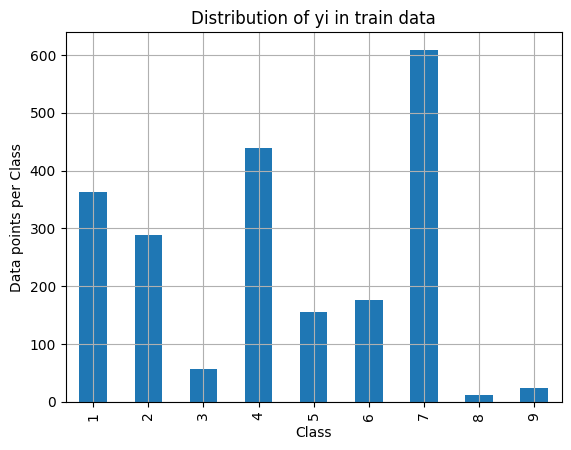

Number of data points in class 7 : 609 ( 28.672 %)
Number of data points in class 4 : 439 ( 20.669 %)
Number of data points in class 1 : 363 ( 17.09 %)
Number of data points in class 2 : 289 ( 13.606 %)
Number of data points in class 6 : 176 ( 8.286 %)
Number of data points in class 5 : 155 ( 7.298 %)
Number of data points in class 3 : 57 ( 2.684 %)
Number of data points in class 9 : 24 ( 1.13 %)
Number of data points in class 8 : 12 ( 0.565 %)
--------------------------------------------------------------------------------


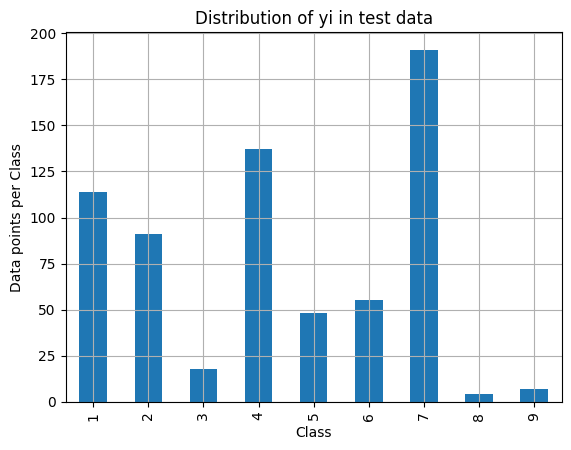

Number of data points in class 7 : 191 ( 28.722 %)
Number of data points in class 4 : 137 ( 20.602 %)
Number of data points in class 1 : 114 ( 17.143 %)
Number of data points in class 2 : 91 ( 13.684 %)
Number of data points in class 6 : 55 ( 8.271 %)
Number of data points in class 5 : 48 ( 7.218 %)
Number of data points in class 3 : 18 ( 2.707 %)
Number of data points in class 9 : 7 ( 1.053 %)
Number of data points in class 8 : 4 ( 0.602 %)
--------------------------------------------------------------------------------


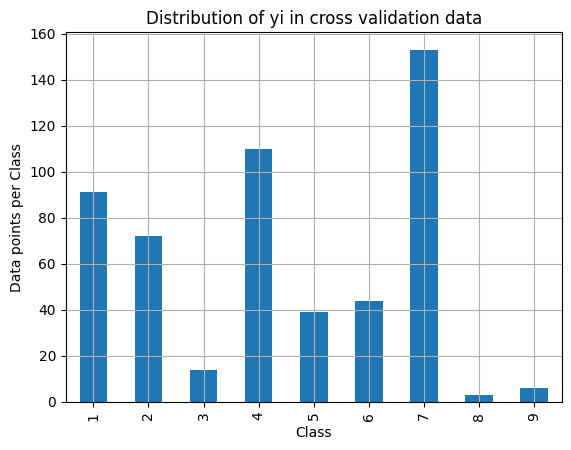

Number of data points in class 7 : 153 ( 28.759 %)
Number of data points in class 4 : 110 ( 20.677 %)
Number of data points in class 1 : 91 ( 17.105 %)
Number of data points in class 2 : 72 ( 13.534 %)
Number of data points in class 6 : 44 ( 8.271 %)
Number of data points in class 5 : 39 ( 7.331 %)
Number of data points in class 3 : 14 ( 2.632 %)
Number of data points in class 9 : 6 ( 1.128 %)
Number of data points in class 8 : 3 ( 0.564 %)


In [16]:
# It returns a dict, keys as class labels and values as the number of data points in that class
train_class_distribution = train_df['Class'].value_counts().sort_index()
test_class_distribution = test_df['Class'].value_counts().sort_index()
cv_class_distribution = cv_df['Class'].value_counts().sort_index()

my_colors = 'rgbkymc'
train_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): The minus sign will give us in decreasing order
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',train_class_distribution.values[i], '(',
      np.round((train_class_distribution.values[i]/train_df.shape[0]*100), 3), '%)')

print('-'*80)
my_colors = 'rgbkymc'
test_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()

sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',test_class_distribution.values[i], '(', np.round((test_class_distribution.values[i]/test_df.shape[0]*100), 3), '%)')

print('-'*80)
my_colors = 'rgbkymc'
cv_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in cross validation data')
plt.grid()
plt.show()

sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',cv_class_distribution.values[i], '(', np.round((cv_class_distribution.values[i]/cv_df.shape[0]*100), 3), '%)')


## 3.2 Предсказание используя 'Random' модель
- В 'Random' модели, мы генерериуем 9 вероятностей принадлежности к классу, их сумма равна 1

In [17]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    C = confusion_matrix(test_y, predict_y)

    # Divide each element of the confusion matrix with the sum of elements in that column
    A = (((C.T)/(C.sum(axis=1))).T)

    # Divide each element of the confusion matrix with the sum of elements in that row
    B =(C/C.sum(axis=0))

    labels = [1,2,3,4,5,6,7,8,9]
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

Log loss on Cross Validation Data using Random Model 2.5508098448625347
Log loss on Test Data using Random Model 2.5056456385758397
-------------------- Confusion matrix --------------------


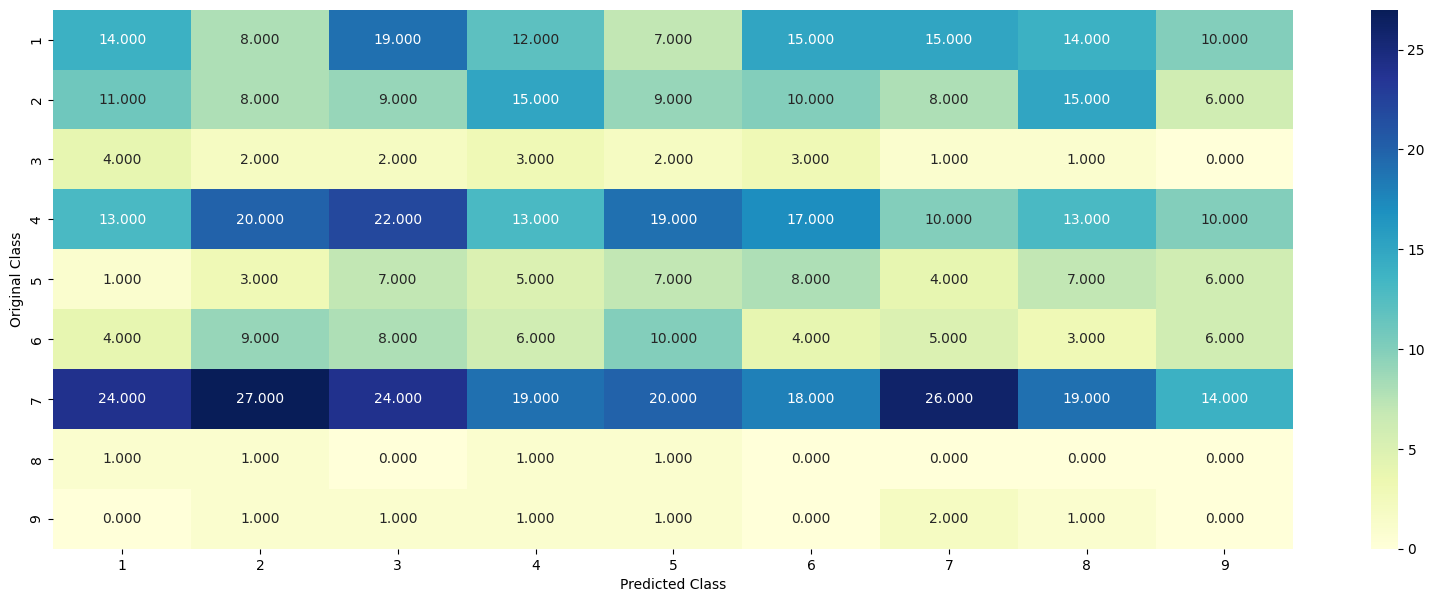

-------------------- Precision matrix (Columm Sum=1) --------------------


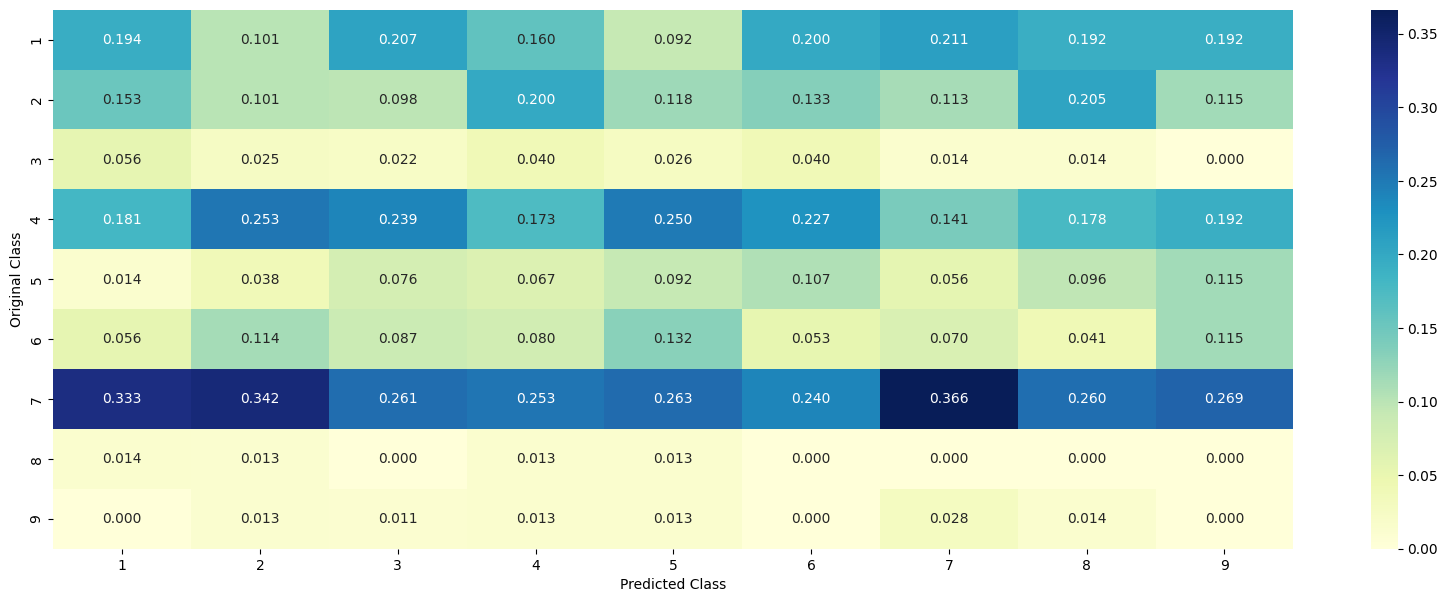

-------------------- Recall matrix (Row sum=1) --------------------


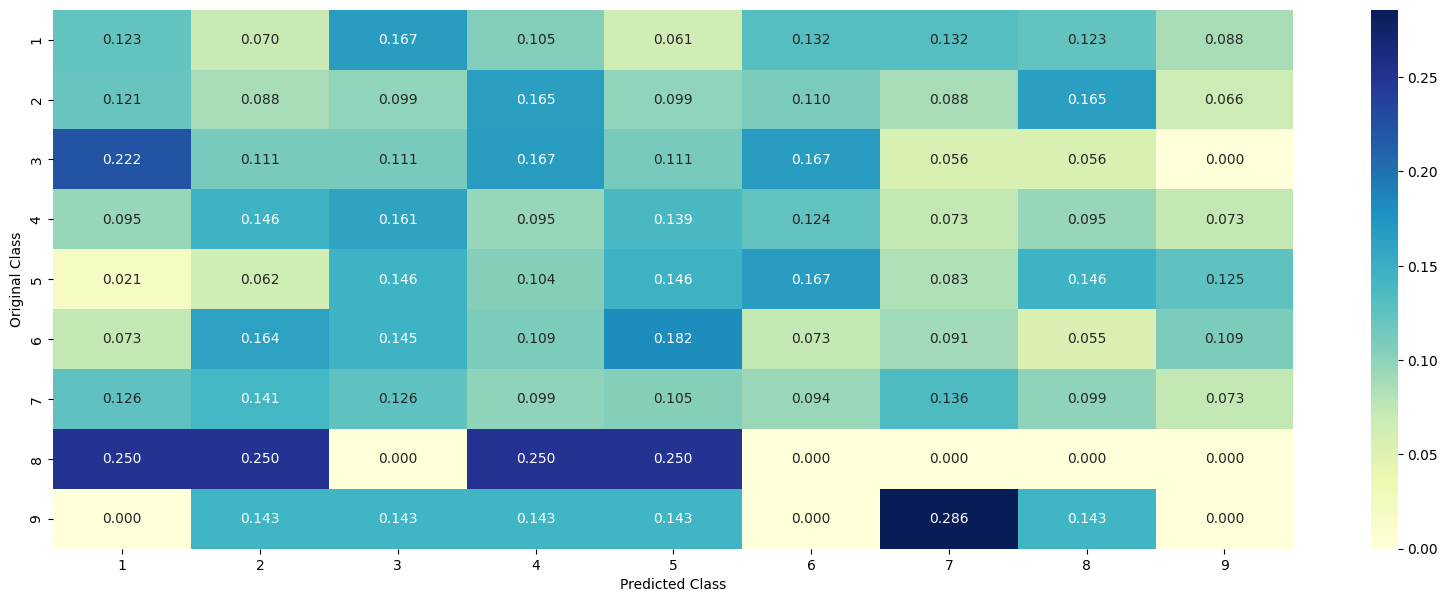

In [18]:
# We need to generate 9 numbers and the sum of numbers should be 1
# One solution is to generate 9 numbers and divide each of the numbers by their sum
# Ref: https://stackoverflow.com/a/18662466/4084039
test_data_len = test_df.shape[0]
cv_data_len = cv_df.shape[0]

# We create an output array that has exactly same size as the CV data
cv_predicted_y = np.zeros((cv_data_len,9))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,9)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Cross Validation Data using Random Model", log_loss(y_cv,cv_predicted_y))

# We create an output array that has exactly same size as the test data
test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model", log_loss(y_test,test_predicted_y))

predicted_y = np.argmax(test_predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y+1)

## 3.3 Одномерный анализ

In [19]:
# Code for response coding with Laplace smoothing.
# alpha : used for laplace smoothing
# feature: ['gene', 'variation']
# df: ['train_df', 'test_df', 'cv_df']
# algorithm
# ----------
# Consider all unique values and the number of occurences of given feature in train data dataframe.
# Build a vector (1*9), the first element = (number of times it occured in class1 + 10*alpha / number of time it occurred in total data+90*alpha)
# gv_dict is like a look up table, for every gene it store a (1*9) representation of it
# For a value of feature in df:
# If it is in train data:
# We add the vector that was stored in 'gv_dict' look up table to 'gv_fea'
# If it is not there in train:
# We add [1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9] to 'gv_fea'
# return 'gv_fea'
# ----------------------

# get_gv_fea_dict: Get Gene Variation Feature Dict
def get_gv_fea_dict(alpha, feature, df):
    # value_count: it contains a dict like
    # print(train_df['Gene'].value_counts())
    # output:
    #        {BRCA1      174
    #         TP53       106
    #         EGFR        86
    #         BRCA2       75
    #         PTEN        69
    #         KIT         61
    #         BRAF        60
    #         ERBB2       47
    #         PDGFRA      46
    #         ...}
    value_count = train_df[feature].value_counts()

    # gv_dict : Gene Variation Dict, which contains the probability array for each gene/variation
    gv_dict = dict()

    # Denominator will contain the number of times that particular feature occured in whole data
    for i, denominator in value_count.items():
        # vec will contain (p(yi==1/Gi) probability of gene/variation belongs to perticular class
        # vec is 9 diamensional vector
        vec = []
        for k in range(1,10):
            # print(train_df.loc[(train_df['Class']==1) & (train_df['Gene']=='BRCA1')])
            #         ID   Gene             Variation  Class
            # 2470  2470  BRCA1                S1715C      1
            # 2486  2486  BRCA1                S1841R      1
            # 2614  2614  BRCA1                   M1R      1
            # 2432  2432  BRCA1                L1657P      1
            # 2567  2567  BRCA1                T1685A      1
            # 2583  2583  BRCA1                E1660G      1
            # 2634  2634  BRCA1                W1718L      1
            # cls_cnt.shape[0] will return the number of rows

            cls_cnt = train_df.loc[(train_df['Class']==k) & (train_df[feature]==i)]

            # cls_cnt.shape[0](numerator) will contain the number of time that particular feature occured in whole data
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))

        # We are adding the gene/variation to the dict as key and vec as value
        gv_dict[i] = vec
    return gv_dict

# Get Gene Variation feature
def get_gv_feature(alpha, feature, df):
    # print(gv_dict)
    #     {'BRCA1': [0.20075757575757575, 0.03787878787878788, 0.068181818181818177, 0.13636363636363635, 0.25, 0.19318181818181818, 0.03787878787878788, 0.03787878787878788, 0.03787878787878788],
    #      'TP53': [0.32142857142857145, 0.061224489795918366, 0.061224489795918366, 0.27040816326530615, 0.061224489795918366, 0.066326530612244902, 0.051020408163265307, 0.051020408163265307, 0.056122448979591837],
    #      'EGFR': [0.056818181818181816, 0.21590909090909091, 0.0625, 0.068181818181818177, 0.068181818181818177, 0.0625, 0.34659090909090912, 0.0625, 0.056818181818181816],
    #      'BRCA2': [0.13333333333333333, 0.060606060606060608, 0.060606060606060608, 0.078787878787878782, 0.1393939393939394, 0.34545454545454546, 0.060606060606060608, 0.060606060606060608, 0.060606060606060608],
    #      'PTEN': [0.069182389937106917, 0.062893081761006289, 0.069182389937106917, 0.46540880503144655, 0.075471698113207544, 0.062893081761006289, 0.069182389937106917, 0.062893081761006289, 0.062893081761006289],
    #      'KIT': [0.066225165562913912, 0.25165562913907286, 0.072847682119205295, 0.072847682119205295, 0.066225165562913912, 0.066225165562913912, 0.27152317880794702, 0.066225165562913912, 0.066225165562913912],
    #      'BRAF': [0.066666666666666666, 0.17999999999999999, 0.073333333333333334, 0.073333333333333334, 0.093333333333333338, 0.080000000000000002, 0.29999999999999999, 0.066666666666666666, 0.066666666666666666],
    #      ...
    #     }
    gv_dict = get_gv_fea_dict(alpha, feature, df)

    # gv_fea: Gene_variation feature, it will contain the feature for each feature value in the data
    gv_fea = []
    # For every feature values in the given data frame we will check if it is there in the train data then we will add the feature to gv_fea
    # If not we will add [1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9] to gv_fea
    for index, row in df.iterrows():
        if row[feature] in gv_dict.keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
    return gv_fea

- Когда мы считаем вероятности принадлжености к классу мы применяем Laplace Smoothing
- (числитель + 10\*alpha) / (знаменатель + 90\*alpha)

### 3.2.1 Одномерный анализ фичей генов

Ген это категориальная переменная и вот как она распределена

In [20]:
unique_genes = train_df['Gene'].value_counts()
print('Number of Unique Genes :', unique_genes.shape[0])

# Top 10 most frequent genes
print(unique_genes.head(10))

print("There are", unique_genes.shape[0] ,"different categories of genes in the train data, and they are distibuted as follows")

Number of Unique Genes : 234
Gene
BRCA1     168
TP53      103
EGFR       96
PTEN       86
BRCA2      84
KIT        60
BRAF       57
ERBB2      48
ALK        44
PDGFRA     43
Name: count, dtype: int64
There are 234 different categories of genes in the train data, and they are distibuted as follows


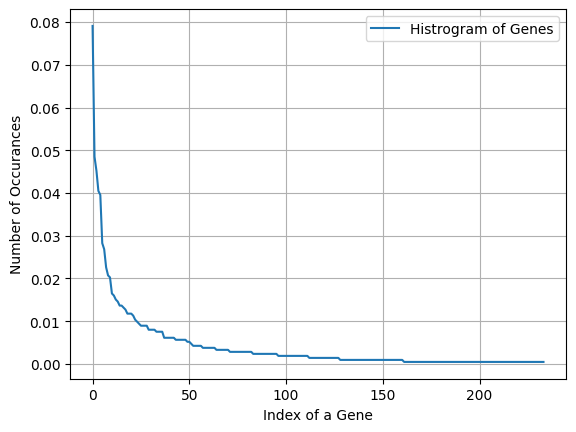

In [21]:
s = sum(unique_genes.values);
h = unique_genes.values/s;
plt.plot(h, label="Histrogram of Genes")
plt.xlabel('Index of a Gene')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

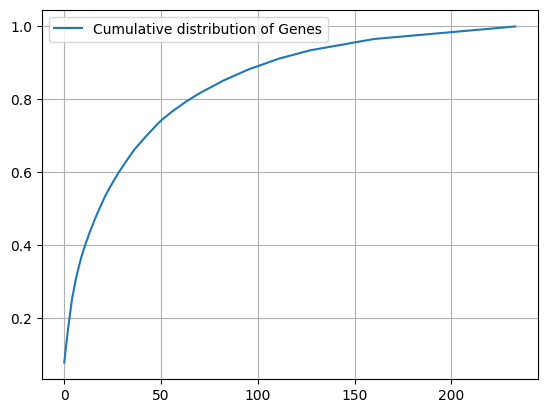

In [22]:
c = np.cumsum(h)
plt.plot(c,label='Cumulative distribution of Genes')
plt.grid()
plt.legend()
plt.show()

 Мы представим фичи генов в виде
    - One hot Encoding
    - Response coding

Это нужно для того, чтобы применить данные для разных моделей

In [23]:
# Response-coding of the Gene feature
# alpha is used for laplace smoothing
alpha = 1
# Train gene feature
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", train_df))
# Test gene feature
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", test_df))
# Cross-Validation gene feature
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", cv_df))

print("train_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature:", train_gene_feature_responseCoding.shape)

train_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature: (2124, 9)


In [24]:
# One-hot encoding of Gene feature.
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

In [25]:
print(train_df['Gene'].head())

69       RHEB
2550    BRCA1
2517    BRCA1
119     PBRM1
563     SMAD3
Name: Gene, dtype: object


In [26]:
print("train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature:", train_gene_feature_onehotCoding.shape)

train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature: (2124, 234)


- **Q4**- Насколько хорошо этот признак гена предсказывает y_i?
- Существует много способов оценить, насколько хорошо признак предсказывает y_i. Один из хороших способов - построить соответствующую ML-модель, используя только этот признак. В данном случае мы построим модель логистической регрессии, используя только признак гена (кодируемый одной точкой) для предсказания y_i.

For values of alpha: 1e-05 The log loss is: 1.2102716387928283
For values of alpha: 0.0001 The log loss is: 1.1899323802684099
For values of alpha: 0.001 The log loss is: 1.2397870049537765
For values of alpha: 0.01 The log loss is: 1.3580824301866536
For values of alpha: 0.1 The log loss is: 1.465667600029853
For values of alpha: 1 The log loss is: 1.4977979589863322


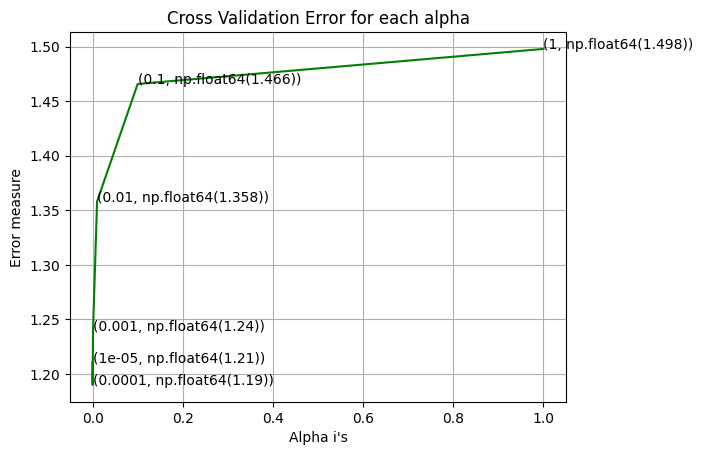

For values of best alpha: 0.0001 The train log loss is: 0.9873543357531516
For values of best alpha: 0.0001 The cross validation log loss is: 1.1899323802684099
For values of best alpha: 0.0001 The test log loss is: 1.2011665480144327


In [27]:
alpha = [10 ** x for x in range(-5, 1)]
cv_log_error_array=[]

for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log_loss', random_state=42)
    clf.fit(train_gene_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_gene_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_))
    print('For values of alpha:', i, "The log loss is:", log_loss(y_cv, predict_y, labels = clf.classes_))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array, c = 'g')
for i, txt in enumerate(np.round(cv_log_error_array, 3)):
    ax.annotate((alpha[i], np.round(txt, 3)), (alpha[i], cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_gene_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_gene_feature_onehotCoding)
print('For values of best alpha:', alpha[best_alpha], "The train log loss is:", log_loss(y_train, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
print('For values of best alpha:', alpha[best_alpha], "The cross validation log loss is:", log_loss(y_cv, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(test_gene_feature_onehotCoding)
print('For values of best alpha:', alpha[best_alpha], "The test log loss is:", log_loss(y_test, predict_y, labels=clf.classes_))

- **Q5**- Является ли функция Gene стабильной во всех наборах данных (Test, Train, Cross validation)?
- **A5**- Да, стабилен. В противном случае ошибки CV и Test были бы значительно больше, чем ошибка Train.

In [28]:
print("Q6. How many data points in Test and CV datasets are covered by the", unique_genes.shape[0], "genes in train dataset?")

test_coverage = test_df[test_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]
cv_coverage = cv_df[cv_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]

print('In test data', test_coverage, 'out of', test_df.shape[0], ":", (test_coverage/test_df.shape[0])*100)
print('In cross-validation data', cv_coverage, 'out of', cv_df.shape[0], ":" , (cv_coverage/cv_df.shape[0])*100)

Q6. How many data points in Test and CV datasets are covered by the 234 genes in train dataset?
In test data 643 out of 665 : 96.69172932330827
In cross-validation data 517 out of 532 : 97.18045112781954


### 3.2.2 Одномерный анализ признака вариации
- **Q7**- Вариация, какой это тип признака?
- **A7**- Вариация - категориальная переменная
- **Q8**- Сколько существует категорий?

In [29]:
unique_variations = train_df['Variation'].value_counts()
print('Number of Unique Variations :', unique_variations.shape[0])

# Top 10 most frequent variations
print(unique_variations.head(10))

print("Ans: There are", unique_variations.shape[0] ,"different categories of variations in the train data, and they are distibuted as follows")

Number of Unique Variations : 1934
Variation
Truncating Mutations    54
Deletion                53
Amplification           49
Fusions                 20
Overexpression           3
E17K                     3
G12V                     2
A146V                    2
Q61R                     2
Y64A                     2
Name: count, dtype: int64
Ans: There are 1934 different categories of variations in the train data, and they are distibuted as follows


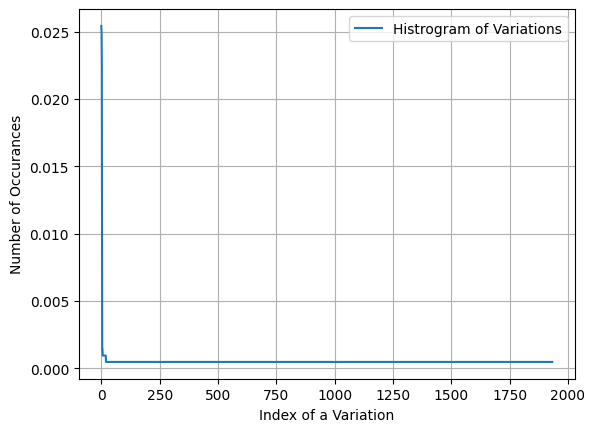

In [30]:
s = sum(unique_variations.values);
h = unique_variations.values/s;
plt.plot(h, label="Histrogram of Variations")
plt.xlabel('Index of a Variation')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

[0.02542373 0.05037665 0.07344633 ... 0.99905838 0.99952919 1.        ]


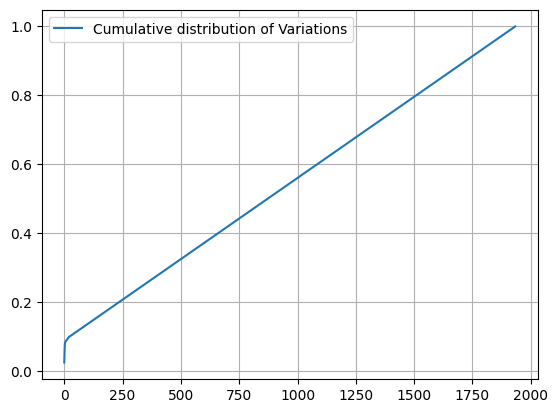

In [31]:
c = np.cumsum(h)
print(c)
plt.plot(c,label='Cumulative distribution of Variations')
plt.grid()
plt.legend()
plt.show()

- **Q9**- Как использовать эту функцию вариации?
- **A9**- Есть два способа использовать эту переменную.
    - Посмотрите это видео: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/
    - One hot кодирование
    - Кодирование ответа
- Мы будем использовать оба этих метода для придания признаку вариативности

In [32]:
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", train_df))
# test gene feature
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", test_df))
# cross validation gene feature
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", cv_df))

print("train_variation_feature_responseCoding is a converted feature using the response coding method. The shape of Variation feature:", train_variation_feature_responseCoding.shape)

train_variation_feature_responseCoding is a converted feature using the response coding method. The shape of Variation feature: (2124, 9)


In [33]:
# One-hot encoding of variation feature
variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])

For values of alpha =  1e-05 The log loss is: 1.6867027815130464
For values of alpha =  0.0001 The log loss is: 1.6807159141410732
For values of alpha =  0.001 The log loss is: 1.6813380362034422
For values of alpha =  0.01 The log loss is: 1.6918215224509
For values of alpha =  0.1 The log loss is: 1.7188074994468159
For values of alpha =  1 The log loss is: 1.7190498901226312


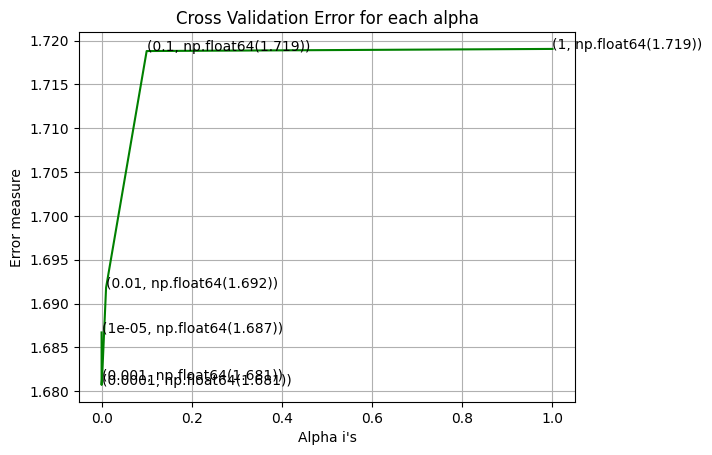

For values of best alpha =  0.0001 The train log loss is: 0.7483223848252444
For values of best alpha =  0.0001 The cross validation log loss is: 1.6807159141410732
For values of best alpha =  0.0001 The test log loss is: 1.69682531231935


In [34]:
alpha = [10 ** x for x in range(-5, 1)]
cv_log_error_array = []

for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log_loss', random_state=42)
    clf.fit(train_variation_feature_onehotCoding, y_train)

    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_variation_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)

    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_variation_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(test_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_))

- **Q11**- Является ли функция Variation стабильной во всех наборах данных (Test, Train, Cross validation)?
- **A11**- Не уверен! Но давайте убедимся в этом с помощью приведенного ниже анализа.

In [35]:
print("Q12. How many data points are covered by total", unique_variations.shape[0], "genes in test and cross validation data sets?")
test_coverage=test_df[test_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
cv_coverage=cv_df[cv_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
print('In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

Q12. How many data points are covered by total 1934 genes in test and cross validation data sets?
In test data 72 out of 665 : 10.827067669172932
In cross validation data 57 out of  532 : 10.714285714285714


### 3.2.3 Одномерный анализ характеристик текста
1. Сколько уникальных слов присутствует в данных тренинга?
2. Как распределены частоты слов?
3. Как обработать текстовое поле?
4. Полезен ли признак текста для предсказания y_i?
5. Стабильна ли текстовая характеристика в тренировочном, тестовом и CV наборах данных?

In [36]:
# cls_text is a data frame
# For every row in data-frame consider the 'TEXT'
# Split the words by space
# Make a dict with those words
# Increment its count whenever we see that word

def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary

In [37]:
# https://stackoverflow.com/a/1602964
# The Data-frame passed to this function might be shuffled in terms of its indices
# And hence, we have maintained a separate`row_index' instead of using the for loop 'index' variable

def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(( (dict_list[i].get(word,0)+10) / (total_dict.get(word,0)+90) ))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responseCoding

In [38]:
# Building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = CountVectorizer(min_df = 3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])

# Getting all the feature names (words)
train_text_features = text_vectorizer.get_feature_names_out()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with the number of times it occured
text_fea_dict = dict(zip(list(train_text_features), train_text_fea_counts))

print("Total number of unique words in train data:", len(train_text_features))

Total number of unique words in train data: 52740


In [39]:
# dict_list = [] contains 9 dictoinaries each corresponds to a class
dict_list = []

for i in range(1,10):
    # Build a word dict based on the words in that class
    cls_text = train_df[train_df['Class']==i]
    # Append it to dict_list
    dict_list.append(extract_dictionary_paddle(cls_text))

# dict_list[i] is build on i'th  class text data
# total_dict is build on whole training text data
total_dict = extract_dictionary_paddle(train_df)

confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append( (dict_list[j][i]+10) / (total_dict[i]+90) )
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [40]:
# Response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(train_df)
test_text_feature_responseCoding  = get_text_responsecoding(test_df)
cv_text_feature_responseCoding  = get_text_responsecoding(cv_df)

In [41]:
# https://stackoverflow.com/a/16202486
# We convert each row values such that they sum to 1
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

In [42]:
# Don't forget to normalize every feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# We use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])
# Don't forget to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# We use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])
# Don't forget to normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [43]:
# https://stackoverflow.com/a/2258273/4084039
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

In [44]:
# Number of words for a given frequency.
print(Counter(sorted_text_occur))

Counter({np.int64(3): 5275, np.int64(4): 3859, np.int64(6): 2981, np.int64(5): 2712, np.int64(7): 2163, np.int64(8): 1803, np.int64(9): 1768, np.int64(11): 1395, np.int64(10): 1279, np.int64(12): 1232, np.int64(13): 1016, np.int64(14): 936, np.int64(15): 772, np.int64(18): 766, np.int64(16): 724, np.int64(17): 587, np.int64(19): 565, np.int64(20): 521, np.int64(21): 507, np.int64(24): 481, np.int64(22): 454, np.int64(23): 388, np.int64(26): 362, np.int64(27): 346, np.int64(28): 339, np.int64(29): 338, np.int64(25): 335, np.int64(43): 329, np.int64(30): 328, np.int64(54): 288, np.int64(32): 288, np.int64(33): 279, np.int64(36): 273, np.int64(31): 251, np.int64(35): 242, np.int64(34): 237, np.int64(40): 220, np.int64(39): 210, np.int64(46): 209, np.int64(37): 202, np.int64(45): 201, np.int64(42): 192, np.int64(38): 184, np.int64(44): 181, np.int64(48): 173, np.int64(41): 173, np.int64(55): 165, np.int64(52): 153, np.int64(56): 149, np.int64(49): 149, np.int64(47): 146, np.int64(50): 143,

For values of alpha =  1e-05 The log loss is: 1.2544319142884461
For values of alpha =  0.0001 The log loss is: 1.1355056273221769
For values of alpha =  0.001 The log loss is: 1.118079148751821
For values of alpha =  0.01 The log loss is: 1.194383321470926
For values of alpha =  0.1 The log loss is: 1.4460635572252698
For values of alpha =  1 The log loss is: 1.6485516291308708


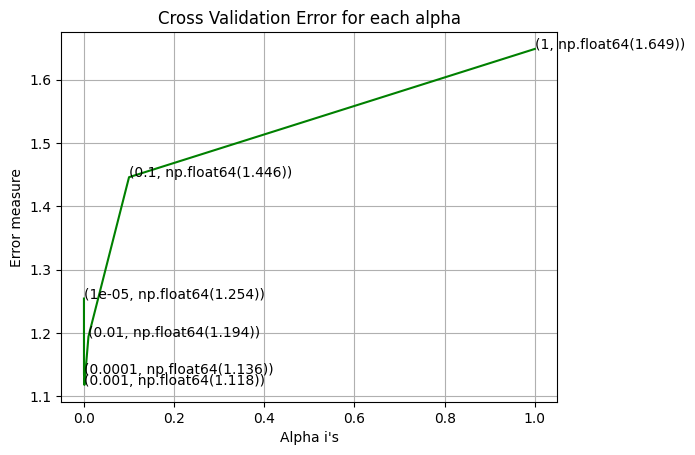

For values of best alpha =  0.001 The train log loss is: 0.6602480818399044
For values of best alpha =  0.001 The cross validation log loss is: 1.118079148751821
For values of best alpha =  0.001 The test log loss is: 1.1112137823091148


In [46]:
# Train a Logistic Regression + Calibration model using text features which are one-hot encoded
alpha = [10 ** x for x in range(-5, 1)]
cv_log_error_array=[]

for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log_loss', random_state=42)
    clf.fit(train_text_feature_onehotCoding, y_train)

    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_))

- **Q**- Является ли функция Text стабильной во всех наборах данных (Test, Train, Cross validation)?
- **A**- Да, похоже на то!

In [49]:
def get_intersec_text(df):
    df_text_vec = CountVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['TEXT'])
    df_text_features = df_text_vec.get_feature_names_out()
    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features),df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1,len2

In [50]:
len1, len2 = get_intersec_text(test_df)
print(np.round((len2/len1)*100, 3), "% of words of Test data appeared in train data")
len1, len2 = get_intersec_text(cv_df)
print(np.round((len2/len1)*100, 3), "% of words of Cross Validation appeared in train data")

97.021 % of words of Test data appeared in train data
97.761 % of words of Cross Validation appeared in train data


# 4. Machine Learning Models

In [51]:
# Data preparation for ML models.
# Misc. functions for ML models

def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # For calculating log_loss, we will provide the array of probabilities belonging to each class
    print("Log loss:", log_loss(test_y, sig_clf.predict_proba(test_x)))
    # Calculating the number of data points that are misclassified
    print("Number of mis-classified points:", np.count_nonzero((pred_y-test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [52]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs)

In [63]:
# Эта функция используется для модели наивного Байеса
# Для заданных индексов признаков она:
# - Определяет, каким источником (Gene, Variation, Text) был сгенерирован признак
# - Проверяет, присутствует ли этот признак в тестовой точке
# - Подсчитывает, сколько важных признаков действительно встречаются в тестовой записи

def get_impfeature_names(indices, text, gene, var, no_features):
    from sklearn.feature_extraction.text import CountVectorizer

    # Создаем векторизаторы для каждого типа признаков
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)

    # Обучаем их на тренировочных данных
    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['TEXT'])

    # Получаем количество признаков в каждом векторизаторе
    fea1_len = len(gene_vec.get_feature_names_out())  # количество признаков из Gene
    fea2_len = len(var_vec.get_feature_names_out())   # из Variation

    word_present = 0  # Счетчик найденных признаков в тестовой точке

    for i, v in enumerate(indices):
        if v < fea1_len:
            # Признак из Gene
            word = gene_vec.get_feature_names_out()[v]
            yes_no = word == gene
            if yes_no:
                word_present += 1
                print(i, f"Gene feature [{word}] present in test data point [{yes_no}]")

        elif v < fea1_len + fea2_len:
            # Признак из Variation
            word = var_vec.get_feature_names_out()[v - fea1_len]
            yes_no = word == var
            if yes_no:
                word_present += 1
                print(i, f"Variation feature [{word}] present in test data point [{yes_no}]")

        else:
            # Признак из TEXT
            word = text_vec.get_feature_names_out()[v - fea1_len - fea2_len]
            yes_no = word in text.split()
            if yes_no:
                word_present += 1
                print(i, f"Text feature [{word}] present in test data point [{yes_no}]")

    print(f"Out of the top {no_features} features, {word_present} are present in the query point")


<p style="font-size:24px;text-align:Center"> <b>Сложение трех типов характеристик </b><p>

In [54]:
# Merging gene, variance and text features
train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(cv_df['Class']))

In [55]:
print("One-hot encoding features:")
print("(Number of data points * Number of features) in train data =", train_x_onehotCoding.shape)
print("(Number of data points * Number of features) in test data =", test_x_onehotCoding.shape)
print("(Number of data points * Number of features) in cross-validation data =", cv_x_onehotCoding.shape)

One-hot encoding features:
(Number of data points * Number of features) in train data = (2124, 54936)
(Number of data points * Number of features) in test data = (665, 54936)
(Number of data points * Number of features) in cross-validation data = (532, 54936)


In [56]:
train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))

In [57]:
print("Response encoding features :")
print("(Number of data points * Number of features) in train data = ", train_x_responseCoding.shape)
print("(Number of data points * Number of features) in test data = ", test_x_responseCoding.shape)
print("(Number of data points * Number of features) in cross-validation data =", cv_x_responseCoding.shape)

Response encoding features :
(Number of data points * Number of features) in train data =  (2124, 27)
(Number of data points * Number of features) in test data =  (665, 27)
(Number of data points * Number of features) in cross-validation data = (532, 27)


## 4.1. Базовая Модель
### 4.1.1. Наивный Байес
#### 4.1.1.1. Настройка гиперпараметров

For alpha = 1e-05
Log Loss: 1.2410327531206773
For alpha = 0.0001
Log Loss: 1.2420537983336761
For alpha = 0.001
Log Loss: 1.243453866370205
For alpha = 0.1
Log Loss: 1.2340061525278014
For alpha = 1
Log Loss: 1.2773184196844876
For alpha = 10
Log Loss: 1.3736403257106549
For alpha = 100
Log Loss: 1.337679975819593
For alpha = 1000
Log Loss: 1.2605563143905898


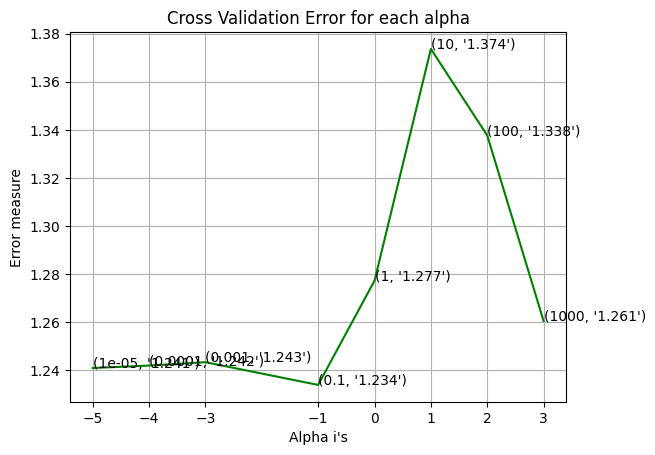

For values of best alpha =  0.1 The train log loss is: 0.8579442534838237
For values of best alpha =  0.1 The cross-validation log loss is: 1.2340061525278014
For values of best alpha =  0.1 The test log loss is: 1.2988371838601314


In [58]:
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []

for i in alpha:
    print("For alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_))
    # To avoid rounding error while multiplying probabilites, we use log-probability estimates
    print("Log Loss:", log_loss(cv_y, sig_clf_probs))

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))

plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:", log_loss(y_train, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross-validation log loss is:", log_loss(y_cv, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:", log_loss(y_test, predict_y, labels=clf.classes_))

#### 4.1.1.2. Тестирование модели с наилучшими гиперпараметрами

Log Loss: 1.2340061525278014
Number of mis-classified points: 0.37593984962406013
-------------------- Confusion matrix --------------------


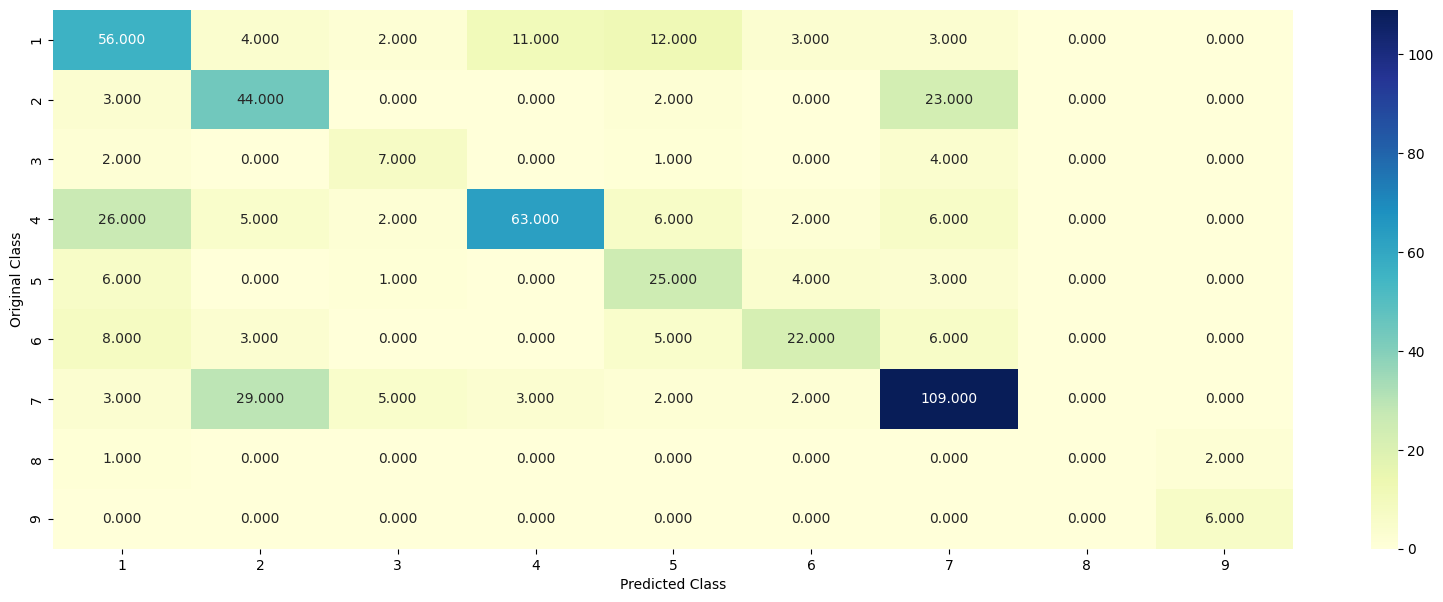

-------------------- Precision matrix (Columm Sum=1) --------------------


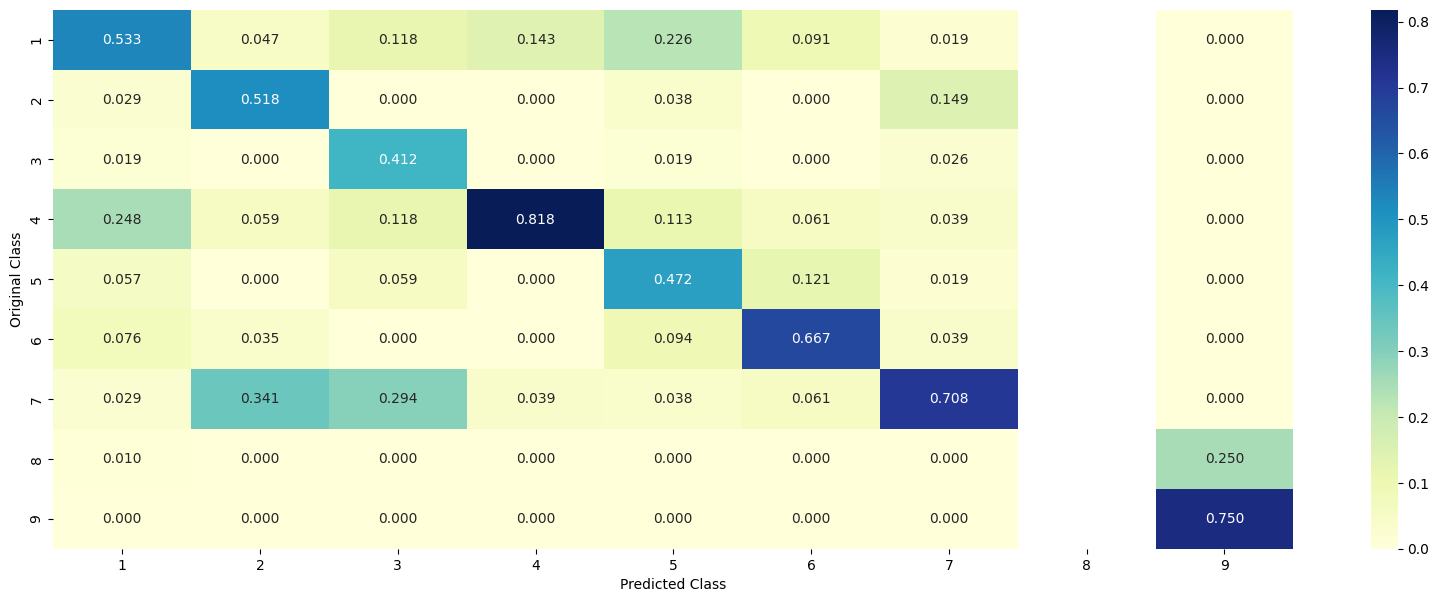

-------------------- Recall matrix (Row sum=1) --------------------


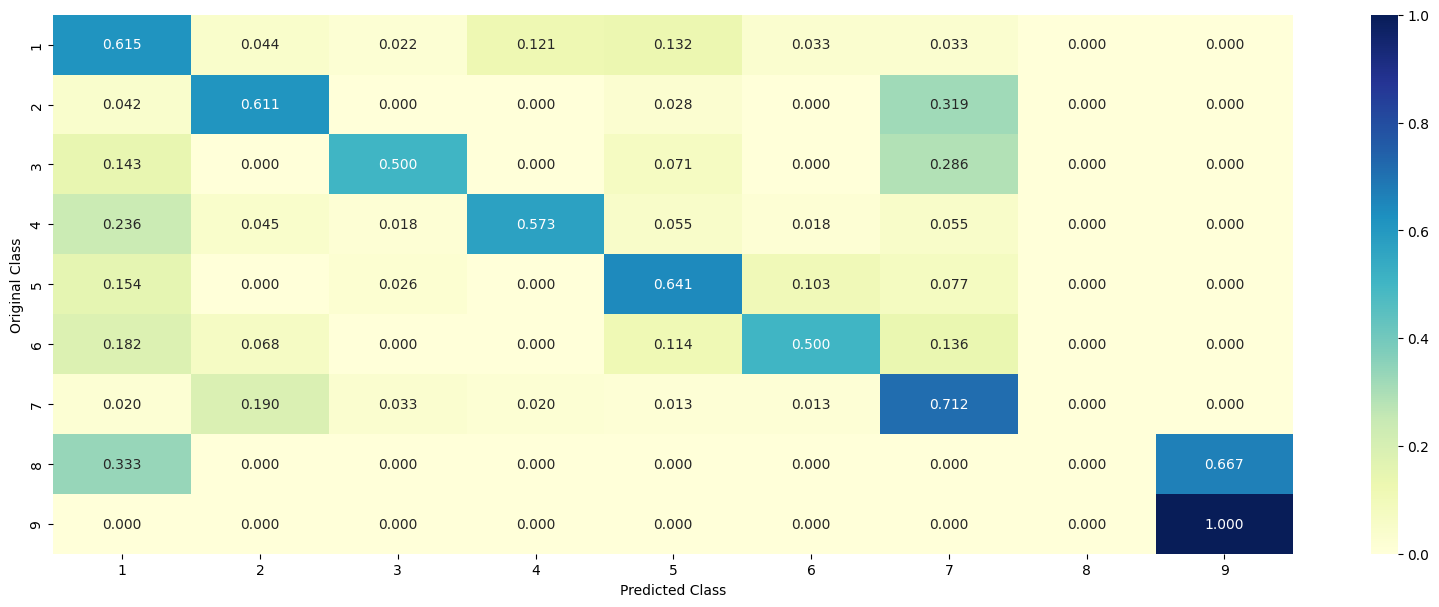

In [59]:
clf = MultinomialNB(alpha = alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)

# To avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss:", log_loss(cv_y, sig_clf_probs))
print("Number of mis-classified points:", np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))

#### 4.1.1.3. Важность признака, правильно классифицированная точка

In [65]:
test_point_index = 0
no_feature = 200

# Предсказание класса и вероятностей
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])[0]
print("Predicted Class:", predicted_cls)
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]), 4))
print("Actual Class:", test_y[test_point_index])

# Получаем логарифмические вероятности признаков для предсказанного класса
log_probs = clf.feature_log_prob_[predicted_cls]

# Получаем индексы top-N самых "важных" признаков
indices = np.argsort(np.abs(log_probs))[::-1][:no_feature]

print("-" * 50)

# Показываем, какие признаки действительно встречаются в тестовой точке
get_impfeature_names(
    indices,
    test_df['TEXT'].iloc[test_point_index],
    test_df['Gene'].iloc[test_point_index],
    test_df['Variation'].iloc[test_point_index],
    no_feature
)


Predicted Class: 1
Predicted Class Probabilities: [[0.5791 0.0778 0.0162 0.121  0.0391 0.0344 0.1238 0.005  0.0035]]
Actual Class: 1
--------------------------------------------------
Out of the top 200 features, 0 are present in the query point


In [66]:
test_point_index = 0
no_feature = 200

# Получаем предсказанный класс
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])[0]

# Вывод предсказаний
print("Predicted Class:", predicted_cls)
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]), 4))
print("Actual Class:", test_y[test_point_index])

# Используем логарифмические вероятности признаков для класса (MultinomialNB)
log_probs = clf.feature_log_prob_[predicted_cls]

# Индексы top-N признаков по модулю значимости
indices = np.argsort(np.abs(log_probs))[::-1][:no_feature]

print("-" * 50)

# Показываем важные признаки
get_impfeature_names(
    indices,
    test_df['TEXT'].iloc[test_point_index],
    test_df['Gene'].iloc[test_point_index],
    test_df['Variation'].iloc[test_point_index],
    no_feature
)


Predicted Class: 1
Predicted Class Probabilities: [[0.5791 0.0778 0.0162 0.121  0.0391 0.0344 0.1238 0.005  0.0035]]
Actual Class: 1
--------------------------------------------------
Out of the top 200 features, 0 are present in the query point


In [68]:
# Вместо clf.coef_ — используем логарифмические вероятности признаков
log_probs = clf.feature_log_prob_[predicted_cls]

# Получаем индексы топ-признаков
indices = np.argsort(np.abs(log_probs))[::-1][:no_feature]

# Выводим размерность и сами индексы
print(clf.feature_log_prob_.shape)
print(indices)


(9, 54936)
[    7    10    11    12    13    14    15    16    55    53    52    51
    50    49    48    60    59    56    69    68    67    64    79    78
    77    76    75    74    72 54871 54869 54868 54867 54879 54878 54876
 54875 54872 54887 54886 54885 54882 54881 54894 54892 54889 54888 54838
 54835 54847 54844 54843 54841 54840 54863 54860 54859    87    86    82
    81    95    94    91    90   103   102    99    98    96   109   107
   106   105 54806 54803 54800 54814 54813 54810 54809 54823 54818 54825
   119   118   116   115   114   113   112   127   124   123   133   132
   130   129   142   141   140   139   137   151   146   159   158   153
   152   167   166   165   164   163   161   175   174   173   172   170
   169   168 54775 54772 54782 54779 54778 54777 54776 54791 54790 54789
 54786 54799 54798 54797 54796 54795 54794 54792 54743 54742 54739 54738
 54737 54736 54749 54747 54744 54759 54758 54757 54756 54755 54754 54753
 54764 54761 54760   183   182   180   1

#### 4.1.1.4. Важность признака, Неправильно классифицированная точка

In [70]:
test_point_index = 1
no_feature = 200

# Предсказание класса и вероятностей
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])[0]
print("Predicted Class:", predicted_cls)
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]), 4))
print("Actual Class:", test_y[test_point_index])

# Используем .feature_log_prob_ вместо .coef_
# log-признаки для предсказанного класса
log_probs = clf.feature_log_prob_[predicted_cls]

# Индексы наиболее значимых признаков
indices = np.argsort(np.abs(log_probs))[::-1][:no_feature]

print("-" * 50)

# Показываем важные признаки
get_impfeature_names(
    indices,
    test_df['TEXT'].iloc[test_point_index],
    test_df['Gene'].iloc[test_point_index],
    test_df['Variation'].iloc[test_point_index],
    no_feature
)


Predicted Class: 7
Predicted Class Probabilities: [[0.0775 0.0681 0.0143 0.1051 0.0337 0.0298 0.6641 0.0043 0.0031]]
Actual Class: 7
--------------------------------------------------
Out of the top 200 features, 0 are present in the query point


## 4.2. Классификация K ближайших соседей
### 4.2.1. Настройка гиперпараметров

For alpha = 5
Log Loss: 1.0604592452432349
For alpha = 11
Log Loss: 1.0673484457226359
For alpha = 15
Log Loss: 1.087957690056135
For alpha = 21
Log Loss: 1.1107484039400364
For alpha = 31
Log Loss: 1.1232619940720183
For alpha = 41
Log Loss: 1.124829865090822
For alpha = 51
Log Loss: 1.1199310543614762
For alpha = 99
Log Loss: 1.1060200583779969


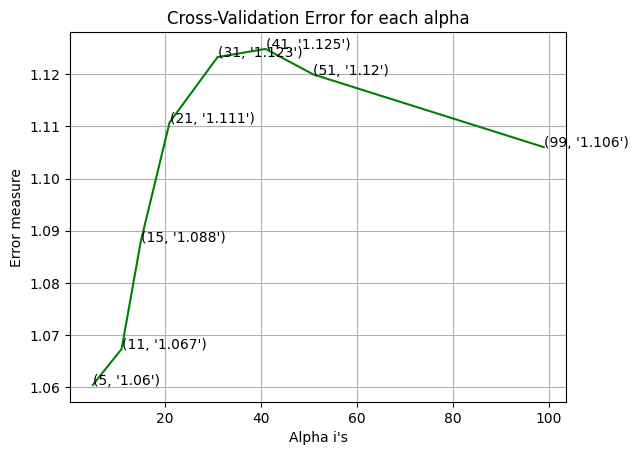

For values of best alpha = 5 The train log loss is: 0.455008525929747
For values of best alpha = 5 The cross-validation log loss is: 1.0604592452432349
For values of best alpha = 5 The test log loss is: 1.0787566295376874


In [71]:
alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []

for i in alpha:
    print("For alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_responseCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_))
    # To avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss:", log_loss(cv_y, sig_clf_probs))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i], cv_log_error_array[i]))
plt.grid()
plt.title("Cross-Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha =', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha =', alpha[best_alpha], "The cross-validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha =', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_))

### 4.2.2. Тестирование модели с наилучшими гиперпараметрами

Log loss: 1.0604592452432349
Number of mis-classified points: 0.3609022556390977
-------------------- Confusion matrix --------------------


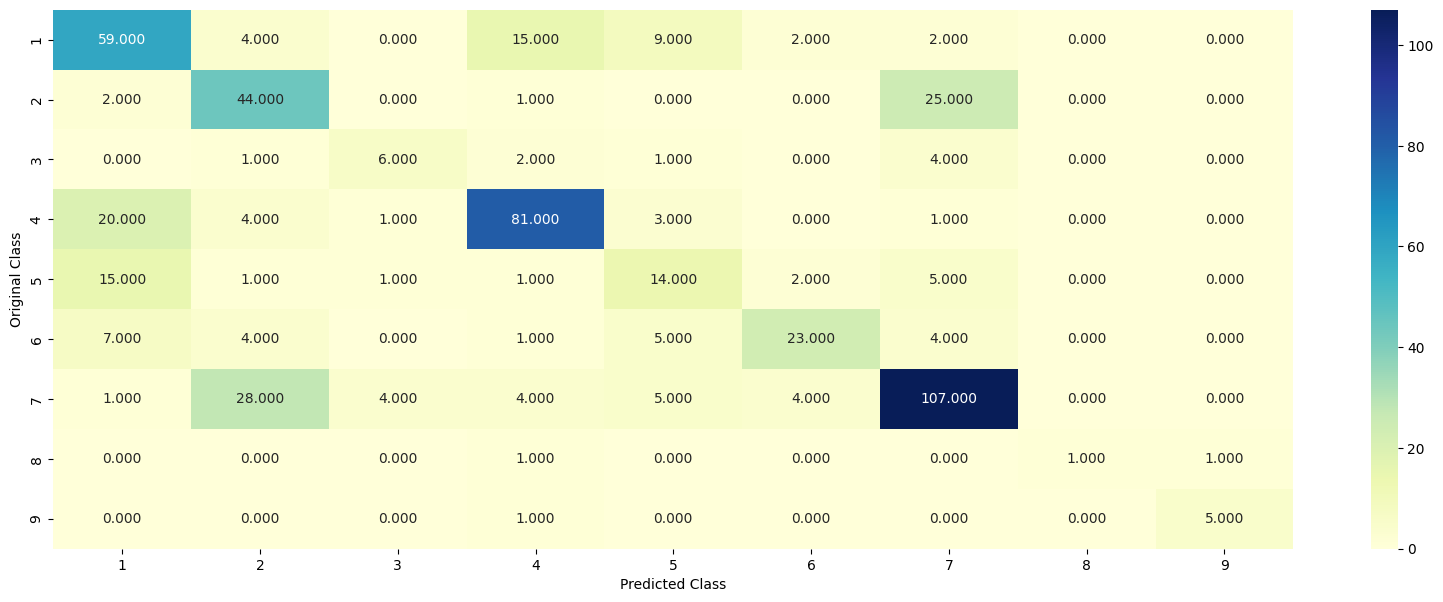

-------------------- Precision matrix (Columm Sum=1) --------------------


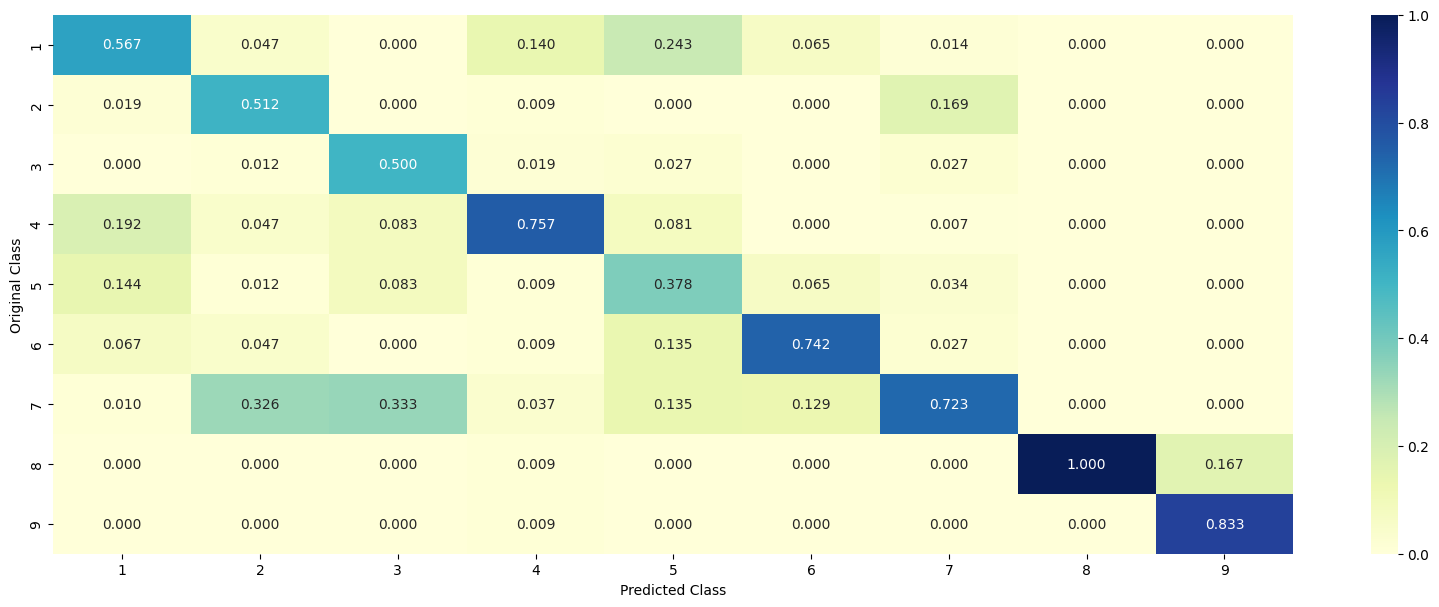

-------------------- Recall matrix (Row sum=1) --------------------


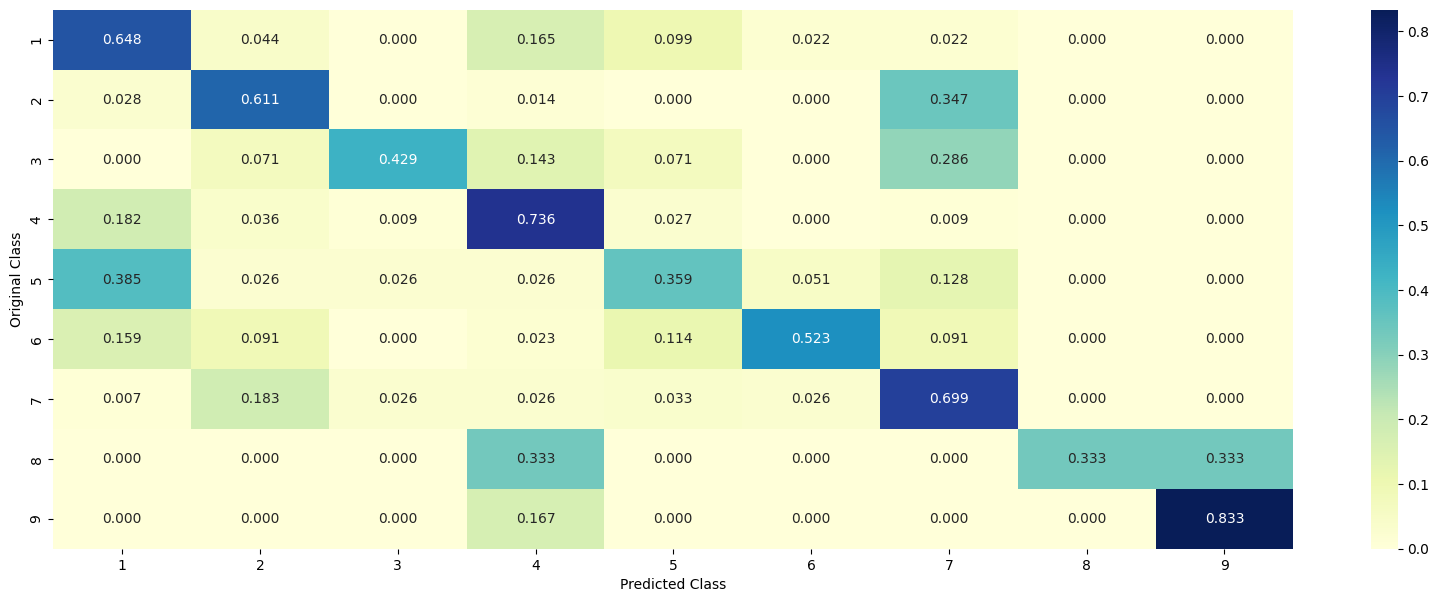

In [72]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y, cv_x_responseCoding, cv_y, clf)

### 4.2.3. Образец точки запроса -1

In [73]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 1
predicted_cls = sig_clf.predict(test_x_responseCoding[0].reshape(1,-1))
print("Predicted Class:", predicted_cls[0])
print("Actual Class:", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The", alpha[best_alpha]," nearest neighbours of the test points belongs to classes", train_y[neighbors[1][0]])
print("Fequency of nearest points:", Counter(train_y[neighbors[1][0]]))

Predicted Class: 1
Actual Class: 7
The 5  nearest neighbours of the test points belongs to classes [7 7 7 7 7]
Fequency of nearest points: Counter({np.int64(7): 5})


### 4.2.4. Точка запроса образца-2

In [74]:
clf = KNeighborsClassifier(n_neighbors = alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 100

predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class:", predicted_cls[0])
print("Actual Class:", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The k value for KNN is",alpha[best_alpha], "and the nearest neighbours of the test points belongs to classes", train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class: 7
Actual Class: 7
The k value for KNN is 5 and the nearest neighbours of the test points belongs to classes [7 7 5 4 7]
Fequency of nearest points : Counter({np.int64(7): 3, np.int64(5): 1, np.int64(4): 1})


## 4.3. Логистическая регрессия
### 4.3.1. С балансировкой классов
#### 4.3.1.1. Настройка гиперпараметров

For alpha = 1e-06
Log Loss: 1.3007226023927587
For alpha = 1e-05
Log Loss: 1.251982569682308
For alpha = 0.0001
Log Loss: 1.0806252244122303
For alpha = 0.001
Log Loss: 1.064106426914682
For alpha = 0.01
Log Loss: 1.109456381121618
For alpha = 0.1
Log Loss: 1.3815087657884606
For alpha = 1
Log Loss: 1.6216224377202308
For alpha = 10
Log Loss: 1.6552330395549824
For alpha = 100
Log Loss: 1.6589109260926076


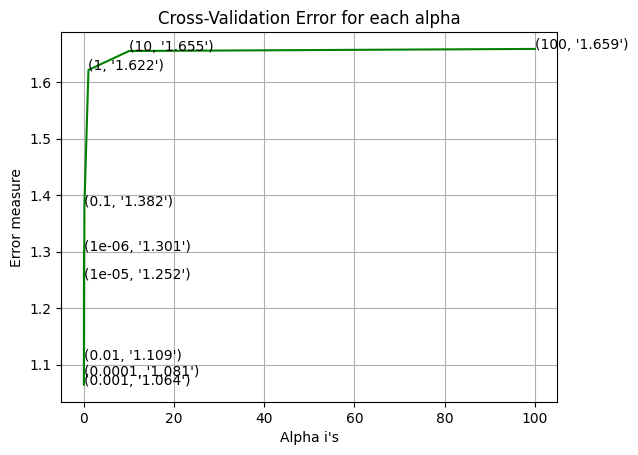

For values of best alpha =  0.001 The train log loss is: 0.5154853746429743
For values of best alpha =  0.001 The cross-validation log loss is: 1.064106426914682
For values of best alpha =  0.001 The test log loss is: 1.0269664731389594


In [75]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []

for i in alpha:
    print("For alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log_loss', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_))
    # To avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss:", log_loss(cv_y, sig_clf_probs))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross-Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:", log_loss(y_train, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross-validation log loss is:", log_loss(y_cv, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:", log_loss(y_test, predict_y, labels=clf.classes_))

#### 4.3.1.2. Тестирование модели с лучшими гиперпараметрами

Log loss: 1.064106426914682
Number of mis-classified points: 0.3383458646616541
-------------------- Confusion matrix --------------------


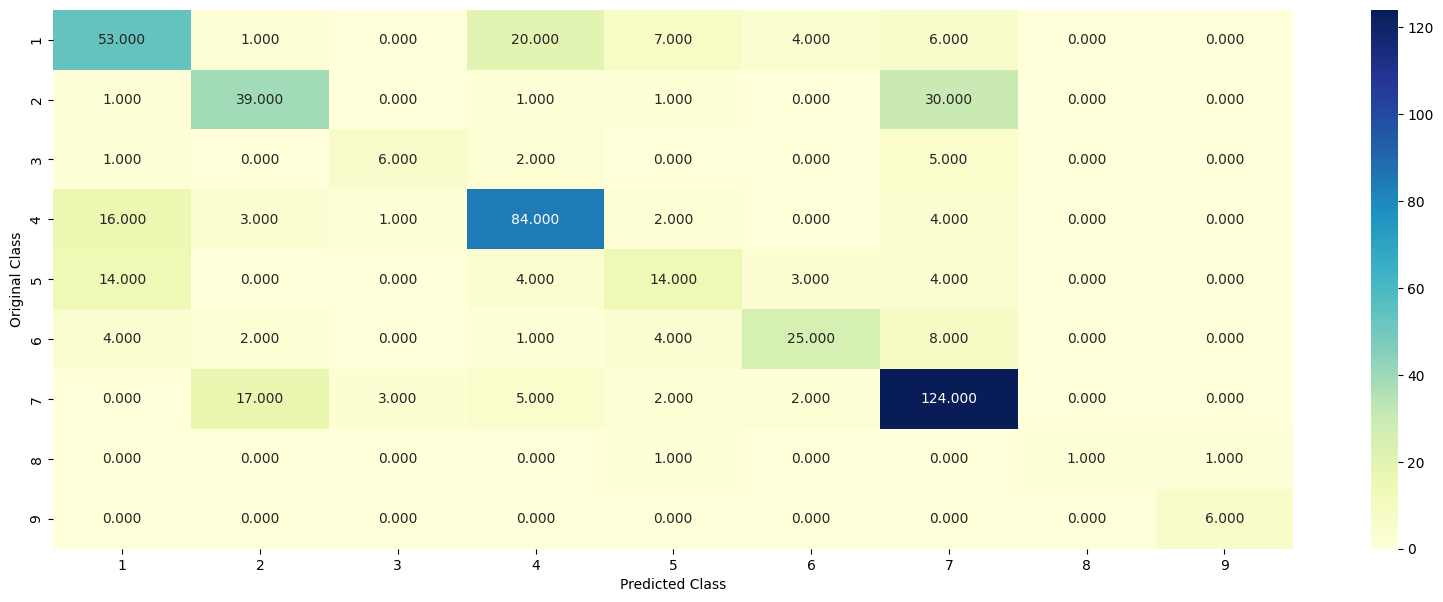

-------------------- Precision matrix (Columm Sum=1) --------------------


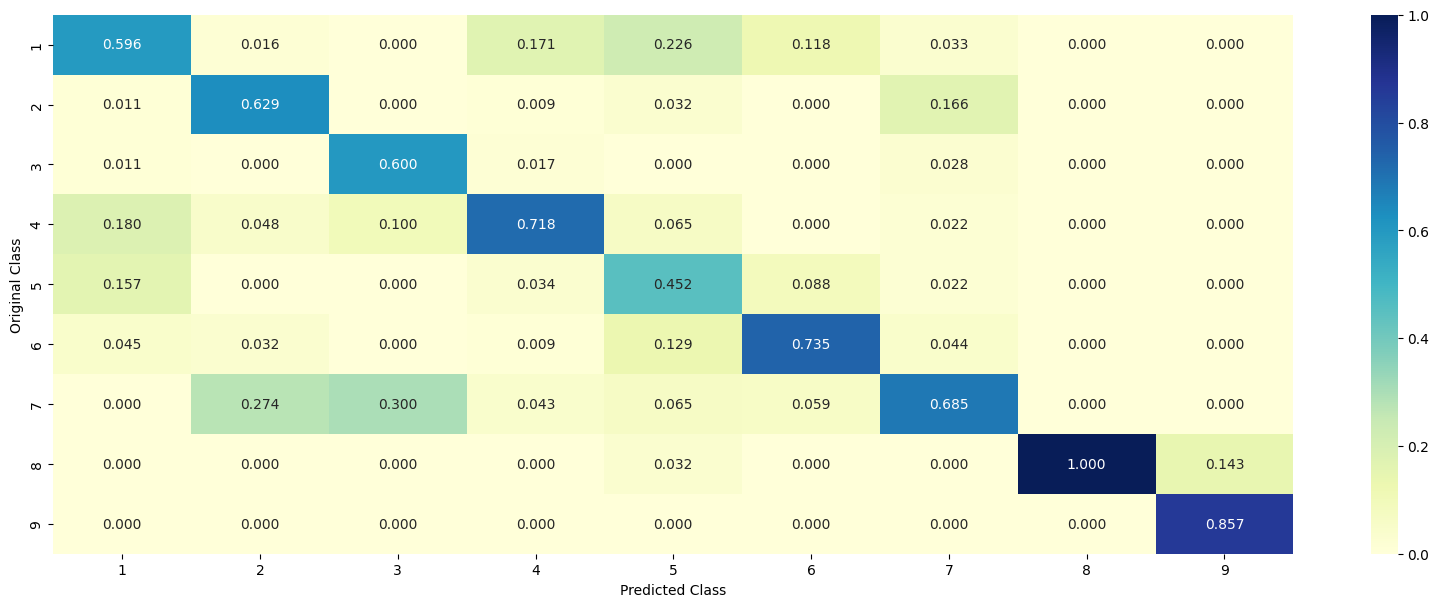

-------------------- Recall matrix (Row sum=1) --------------------


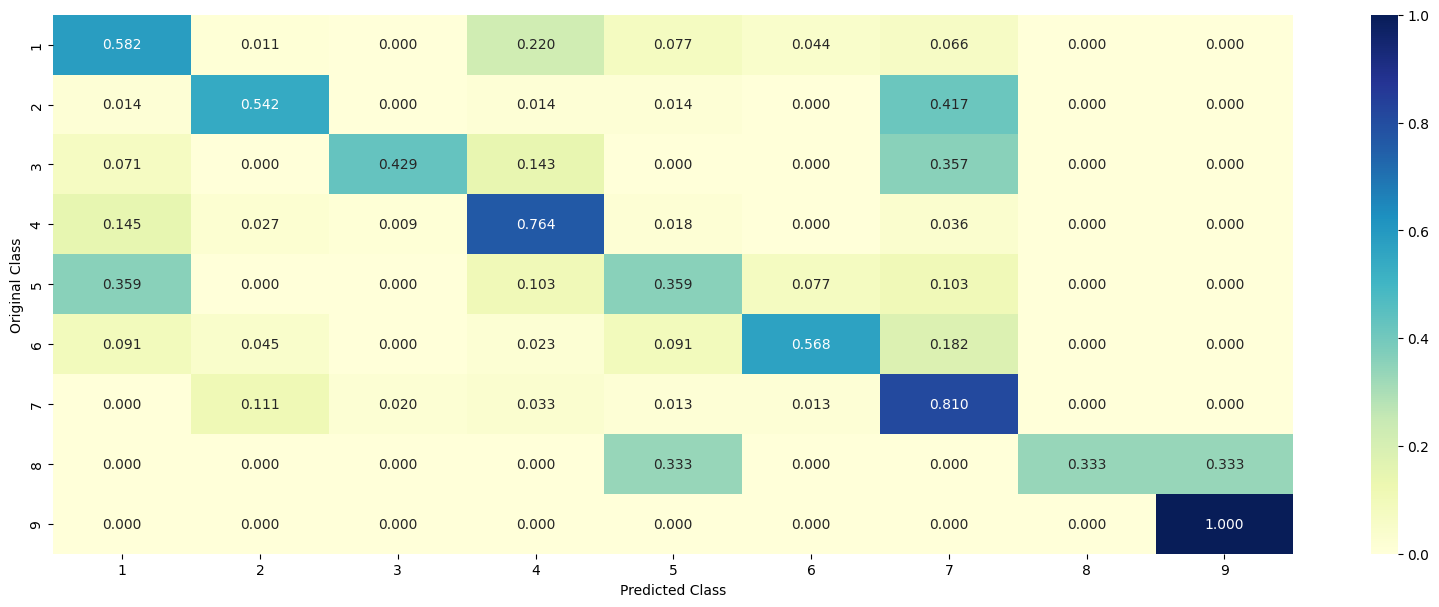

In [76]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log_loss',
    random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

#### 4.3.1.3. Важность характеристик

In [77]:
def get_imp_feature_names(text, indices, removed_ind = []):
    word_present = 0
    tabulte_list = []
    incresingorder_ind = 0
    for i in indices:
        if i < train_gene_feature_onehotCoding.shape[1]:
            tabulte_list.append([incresingorder_ind, "Gene", "Yes"])
        elif i< 18:
            tabulte_list.append([incresingorder_ind,"Variation", "Yes"])
        if ((i > 17) & (i not in removed_ind)) :
            word = train_text_features[i]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
            tabulte_list.append([incresingorder_ind,train_text_features[i], yes_no])
        incresingorder_ind += 1
    print(word_present, "most importent features are present in our query point")
    print("-"*50)
    print("The features that are most importent of the", predicted_cls[0], "class:")
    print (tabulate(tabulte_list, headers=["Index", 'Feature name', 'Present or Not']))

##### 4.3.1.3.1. Правильно классифицированная точка

In [78]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class:", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class:", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],
    test_df['Gene'].iloc[test_point_index], test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class: 7
Predicted Class Probabilities: [[0.00e+00 3.20e-03 1.00e-04 2.00e-04 6.60e-03 0.00e+00 9.86e-01 3.60e-03
  2.00e-04]]
Actual Class: 7
--------------------------------------------------
87 Text feature [constitutive] present in test data point [True]
92 Text feature [transforming] present in test data point [True]
97 Text feature [constitutively] present in test data point [True]
120 Text feature [y1068] present in test data point [True]
131 Text feature [3t3] present in test data point [True]
150 Text feature [nonsense] present in test data point [True]
162 Text feature [activated] present in test data point [True]
187 Text feature [putative] present in test data point [True]
219 Text feature [remove] present in test data point [True]
222 Text feature [nude] present in test data point [True]
245 Text feature [suppressor] present in test data point [True]
254 Text feature [ligand] present in test data point [True]
257 Text feature [neu] present in test data point [Tru

##### 4.3.1.3.2. Неправильно классифицированная точка

In [79]:
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class:", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class:", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],
    test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class: 7
Predicted Class Probabilities: [[0.0259 0.0736 0.0126 0.0266 0.0293 0.025  0.7979 0.0054 0.0036]]
Actual Class: 7
--------------------------------------------------
87 Text feature [constitutive] present in test data point [True]
92 Text feature [transforming] present in test data point [True]
131 Text feature [3t3] present in test data point [True]
133 Text feature [missense] present in test data point [True]
162 Text feature [activated] present in test data point [True]
245 Text feature [suppressor] present in test data point [True]
309 Text feature [activation] present in test data point [True]
315 Text feature [oncogene] present in test data point [True]
332 Text feature [glutamic] present in test data point [True]
350 Text feature [predicted] present in test data point [True]
376 Text feature [tk] present in test data point [True]
378 Text feature [function] present in test data point [True]
392 Text feature [stability] present in test data point [True]
394 Text

<h3>4.3.2. Без балансировки классов</h3>
<h4>4.3.2.1. Настройка гиперпараметров</h4>

For alpha = 1e-06
Log Loss : 1.277691417024841
For alpha = 1e-05
Log Loss : 1.2399559145676131
For alpha = 0.0001
Log Loss : 1.0951932547276588
For alpha = 0.001
Log Loss : 1.0642022124601613
For alpha = 0.01
Log Loss : 1.1215715902455972
For alpha = 0.1
Log Loss : 1.3559689770897527
For alpha = 1
Log Loss : 1.5930508850451175


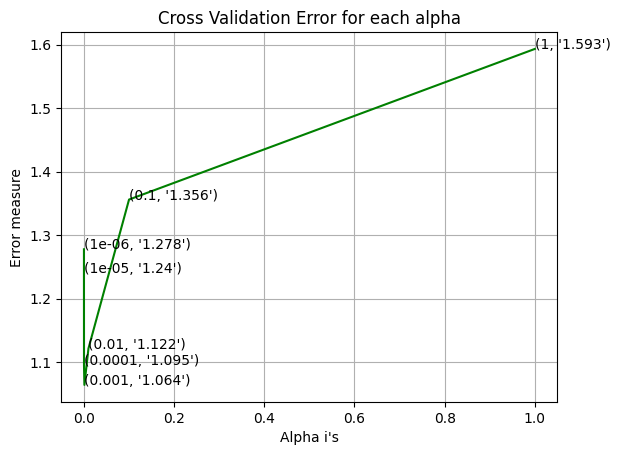

For values of best alpha =  0.001 The train log loss is: 0.5164173145809302
For values of best alpha =  0.001 The cross-validation log loss is: 1.0642022124601613
For values of best alpha =  0.001 The test log loss is: 1.035804915940129


In [80]:
alpha = [10 ** x for x in range(-6, 1)]
cv_log_error_array = []

for i in alpha:
    print("For alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log_loss', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross-validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_))

#### 4.3.2.2. Тестирование модели с наилучшими гиперпараметрами

Log loss: 1.0642022124601613
Number of mis-classified points: 0.34398496240601506
-------------------- Confusion matrix --------------------


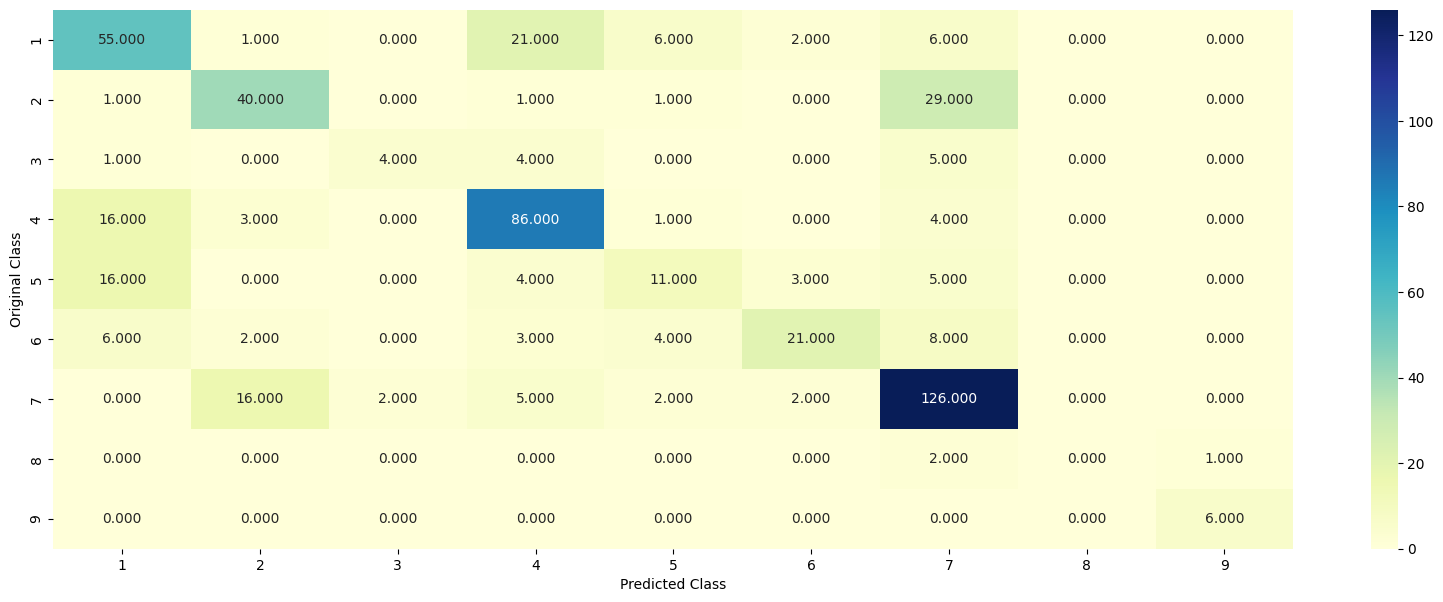

-------------------- Precision matrix (Columm Sum=1) --------------------


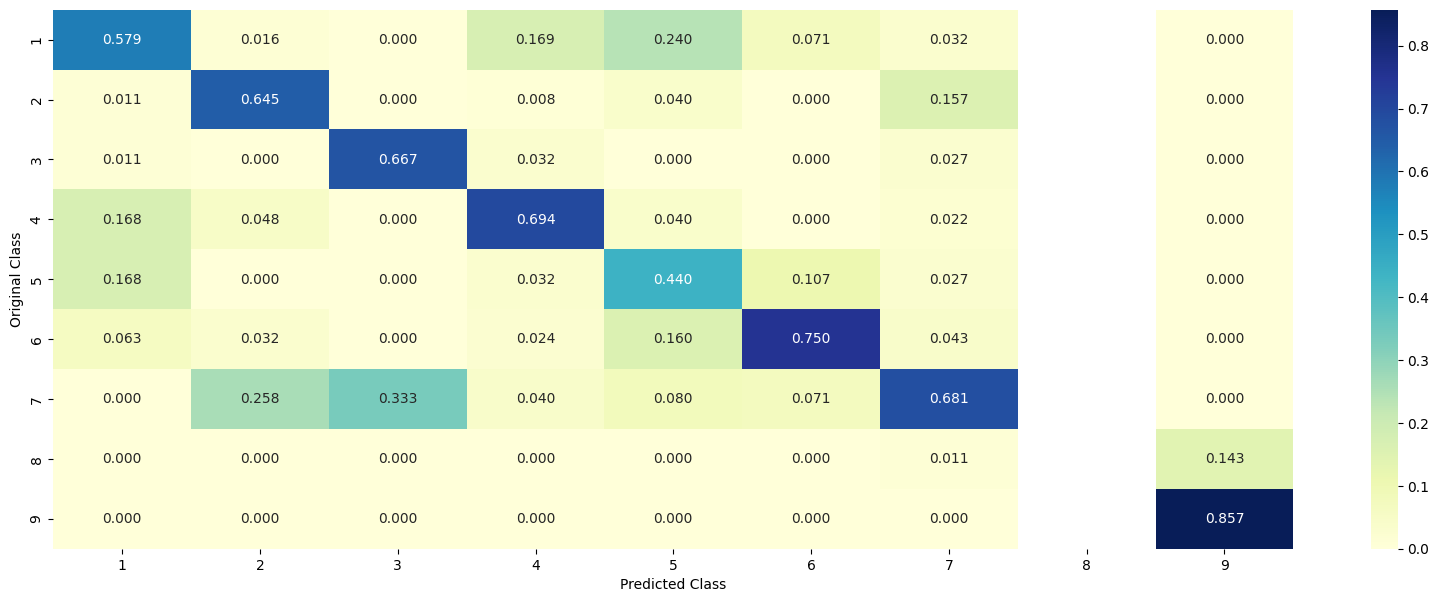

-------------------- Recall matrix (Row sum=1) --------------------


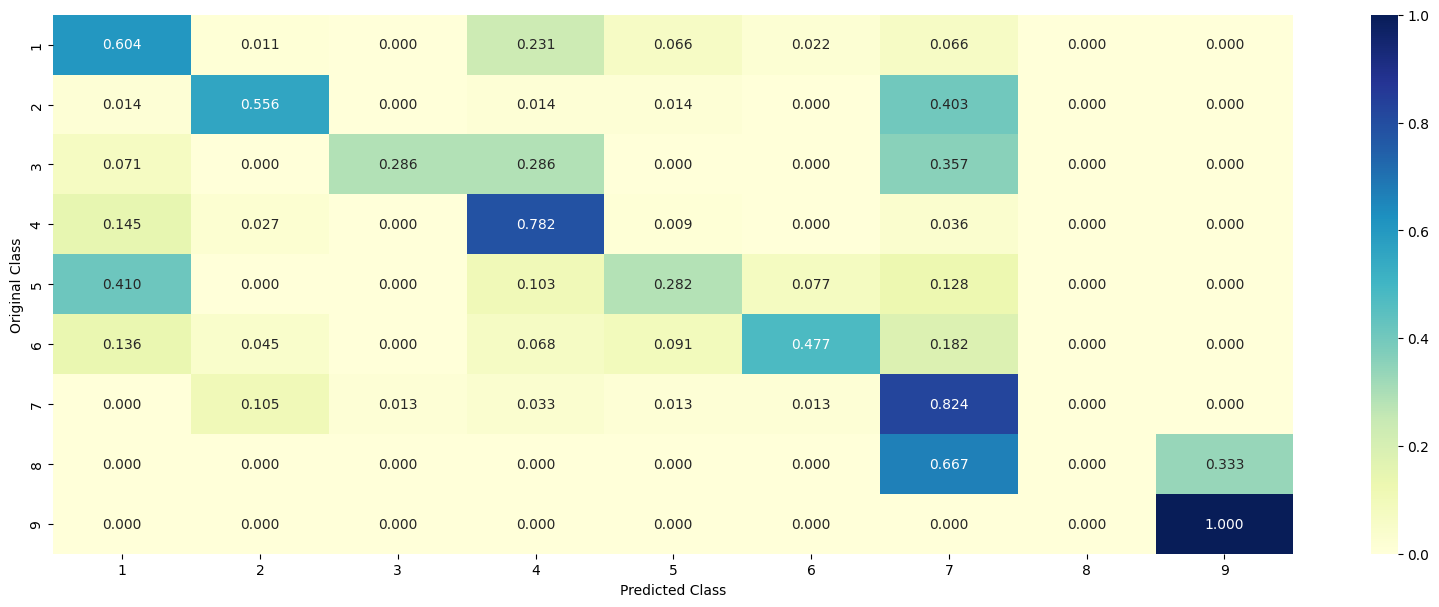

In [81]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

#### 4.3.2.3. Важность признака, правильно классифицированная точка

In [82]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[1.000e-04 3.600e-03 1.000e-04 7.000e-04 3.900e-03 0.000e+00 9.882e-01
  3.500e-03 0.000e+00]]
Actual Class : 7
--------------------------------------------------
143 Text feature [transforming] present in test data point [True]
183 Text feature [constitutive] present in test data point [True]
207 Text feature [constitutively] present in test data point [True]
218 Text feature [3t3] present in test data point [True]
239 Text feature [y1068] present in test data point [True]
295 Text feature [activated] present in test data point [True]
357 Text feature [transformed] present in test data point [True]
394 Text feature [counteracts] present in test data point [True]
397 Text feature [nude] present in test data point [True]
432 Text feature [putative] present in test data point [True]
433 Text feature [ligand] present in test data point [True]
454 Text feature [nonsense] present in test data point [True]
458 Text feature [neu] present in 

#### 4.3.2.4. Важность признака, неверно классифицированная точка

In [83]:
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0264 0.0762 0.0125 0.0273 0.0304 0.0242 0.7951 0.0058 0.0022]]
Actual Class : 7
--------------------------------------------------
143 Text feature [transforming] present in test data point [True]
183 Text feature [constitutive] present in test data point [True]
218 Text feature [3t3] present in test data point [True]
295 Text feature [activated] present in test data point [True]
361 Text feature [glutamic] present in test data point [True]
403 Text feature [technology] present in test data point [True]
467 Text feature [missense] present in test data point [True]
489 Text feature [activating] present in test data point [True]
499 Text feature [activation] present in test data point [True]
Out of the top 500 features, 9 are present in the query point


## 4.4. Метод линейных опорных вектором (LSTM)
### 4.4.1. Настройка гиперпараметров

for C = 1e-05
Log Loss : 1.2442015621943132
for C = 0.0001
Log Loss : 1.1649825822891822
for C = 0.001
Log Loss : 1.0919767637190945
for C = 0.01
Log Loss : 1.1212680812419238
for C = 0.1
Log Loss : 1.2956079521940542
for C = 1
Log Loss : 1.6423192102075703
for C = 10
Log Loss : 1.6595505007502485
for C = 100
Log Loss : 1.6595504983705551


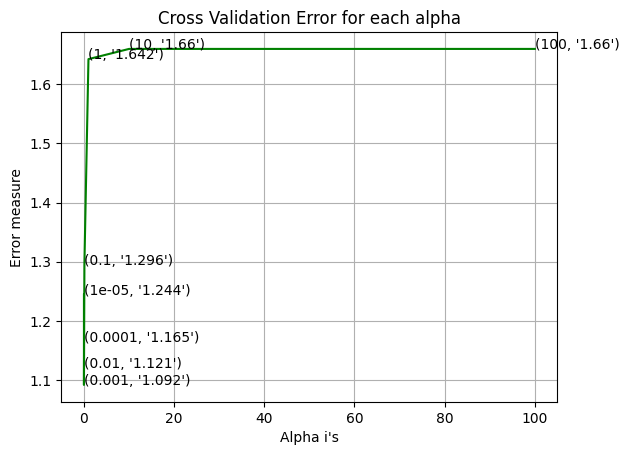

For values of best alpha =  0.001 The train log loss is: 0.5178512179990818
For values of best alpha =  0.001 The cross-validation log loss is: 1.0919767637190945
For values of best alpha =  0.001 The test log loss is: 1.121536322843514


In [84]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
    # clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross-validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_))

### 4.4.2. Тестирование модели с наилучшими гиперпараметрами

Log loss: 1.0919767637190945
Number of mis-classified points: 0.34398496240601506
-------------------- Confusion matrix --------------------


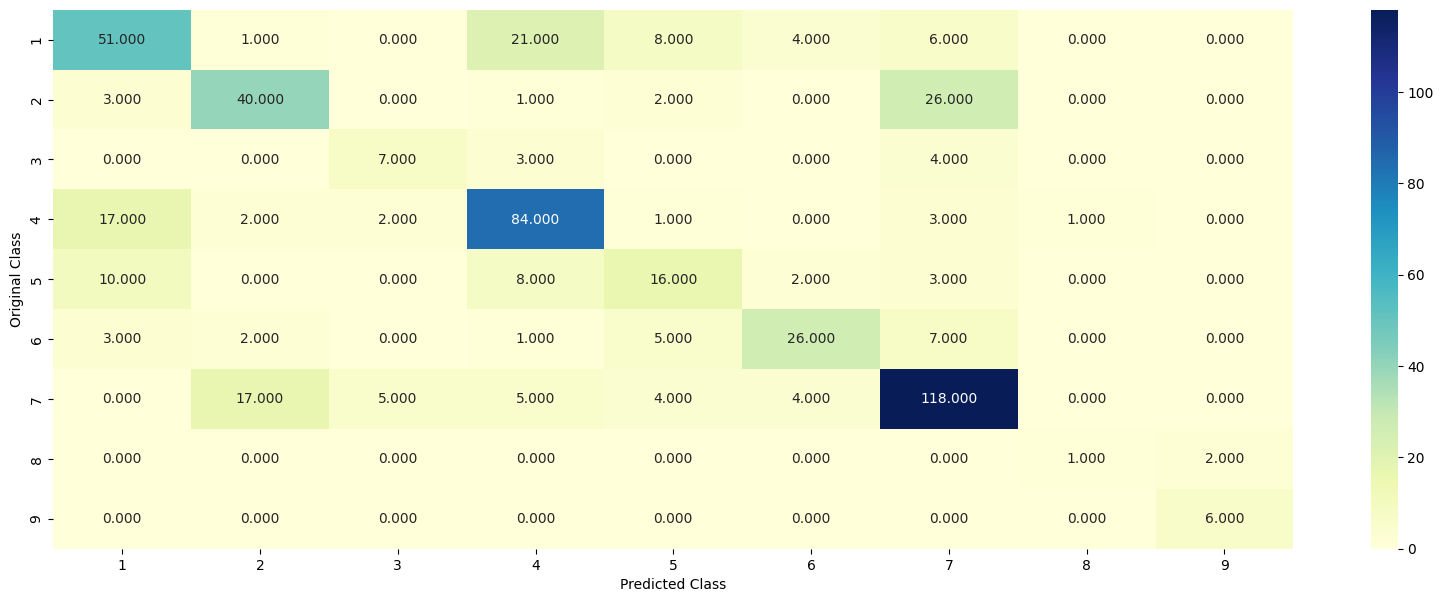

-------------------- Precision matrix (Columm Sum=1) --------------------


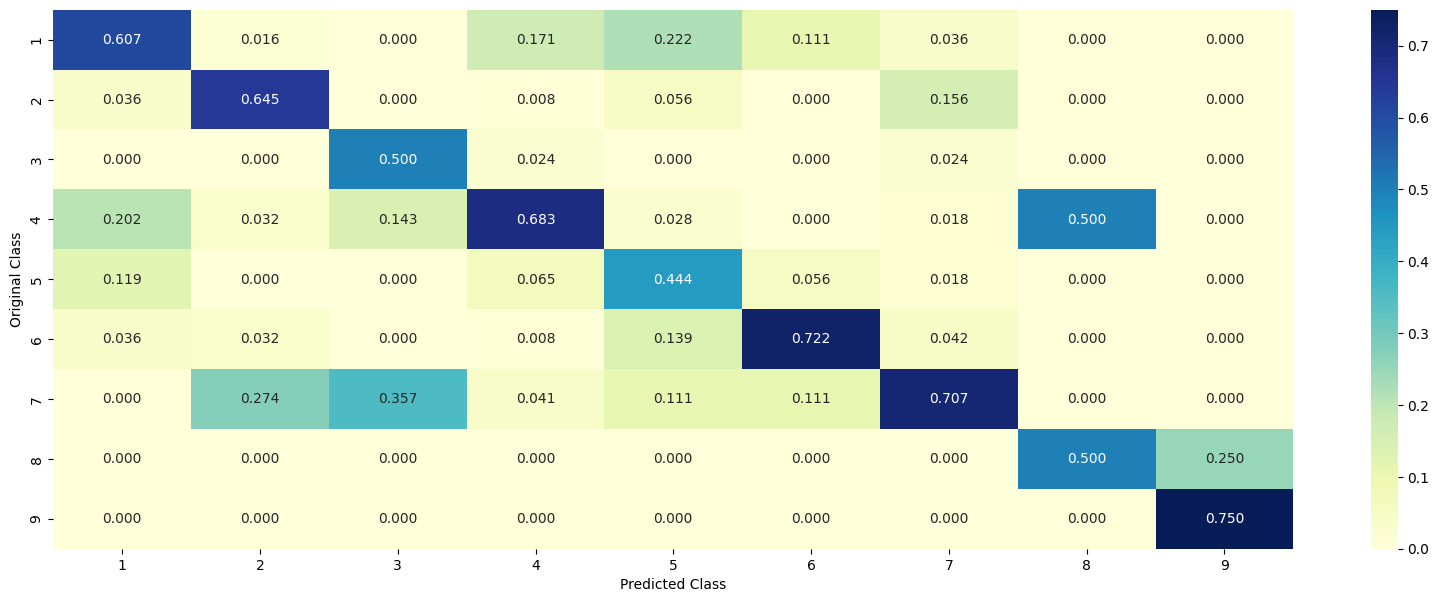

-------------------- Recall matrix (Row sum=1) --------------------


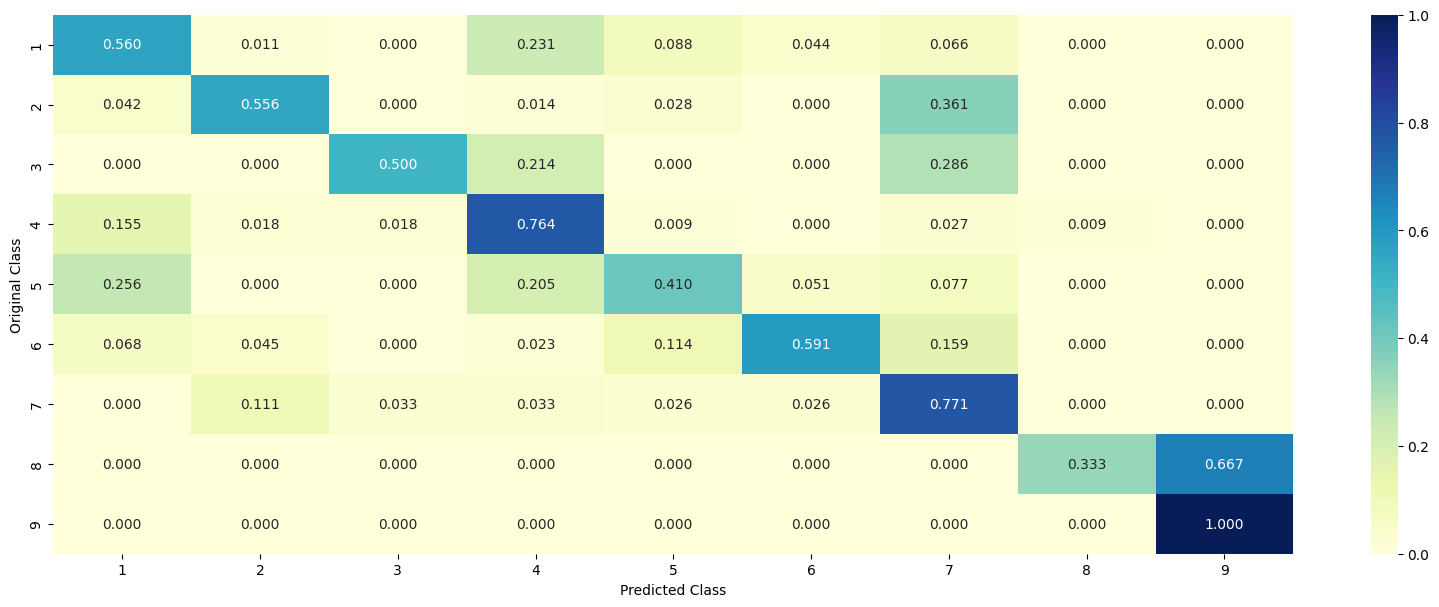

In [85]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42,
    class_weight='balanced')
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

### 4.3.3. Важность характеристик
#### 4.3.3.1. Для правильно классифицированной точки

In [86]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0703 0.07   0.0169 0.0815 0.0346 0.056  0.6607 0.0045 0.0054]]
Actual Class : 7
--------------------------------------------------
440 Text feature [3t3] present in test data point [True]
Out of the top 500 features, 1 are present in the query point


#### 4.3.3.2. Для неправильно классифицированной точки

In [87]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0083 0.0071 0.0025 0.0399 0.0185 0.0016 0.9183 0.002  0.0018]]
Actual Class : 7
--------------------------------------------------
355 Text feature [swab] present in test data point [True]
440 Text feature [3t3] present in test data point [True]
491 Text feature [counteracts] present in test data point [True]
Out of the top 500 features, 3 are present in the query point


## 4.5 Классификатор Random Forest
### 4.5.1. Настройка гиперпараметров (с one hot кодированием)

In [88]:
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []

for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_onehotCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehotCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs))

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross-validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_))

for n_estimators = 100 and max depth =  5
Log Loss : 1.2655250055222456
for n_estimators = 100 and max depth =  10
Log Loss : 1.177381671264613
for n_estimators = 200 and max depth =  5
Log Loss : 1.2515016633780582
for n_estimators = 200 and max depth =  10
Log Loss : 1.1621878036594226
for n_estimators = 500 and max depth =  5
Log Loss : 1.241550642632751
for n_estimators = 500 and max depth =  10
Log Loss : 1.160842861025924
for n_estimators = 1000 and max depth =  5
Log Loss : 1.2394825397441456
for n_estimators = 1000 and max depth =  10
Log Loss : 1.161751199824555
for n_estimators = 2000 and max depth =  5
Log Loss : 1.2342272720418204
for n_estimators = 2000 and max depth =  10
Log Loss : 1.1589814401427387
For values of best estimator =  2000 The train log loss is: 0.7167906385809235
For values of best estimator =  2000 The cross-validation log loss is: 1.1589814401427387
For values of best estimator =  2000 The test log loss is: 1.1560954419757736


### 4.5.2. Тестирование модели с наилучшими гиперпараметрами (One Hot Encoding)

In [89]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini',
    max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

KeyboardInterrupt: 

### 4.5.3. Важность характеристик
#### 4.5.3.1. Правильно классифицированная точка

In [ ]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

test_point_index = 100
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

#### 4.5.3.2. Неправильно классифицированная точка

In [ ]:
test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actuall Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

### 4.5.3. Настройка гиперпараметров (с кодированием отклика)

In [ ]:
alpha = [10,50,100,200,500,1000]
max_depth = [2,3,5,10]
cv_log_error_array = []

for i in alpha:
    for j in max_depth:
        print("For n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_responseCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_responseCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs))

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The cross-validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_))

### 4.5.4. Тестирование модели с наилучшими гиперпараметрами (Кодирование ответа)

In [ ]:
clf = RandomForestClassifier(max_depth=max_depth[int(best_alpha%4)], n_estimators=alpha[int(best_alpha/4)],
    criterion='gini', max_features='auto',random_state=42)
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y,cv_x_responseCoding,cv_y, clf)

### 4.5.5. Важность характеристик
#### 4.5.5.1. Правильно классифицированная точка

In [ ]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 1
no_feature = 27
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

#### 4.5.5.2. Неправильно классифицированная точка

In [ ]:
test_point_index = 3
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

## 4.7 Стакинг моделей
### 4.7.1 Тестирование с помощью настройки гиперпараметров

In [ ]:
clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log_loss', class_weight='balanced', random_state=0)
clf1.fit(train_x_onehotCoding, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_x_onehotCoding, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")

clf3 = MultinomialNB(alpha=0.001)
clf3.fit(train_x_onehotCoding, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(train_x_onehotCoding, train_y)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf1.predict_proba(cv_x_onehotCoding))))
sig_clf2.fit(train_x_onehotCoding, train_y)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf2.predict_proba(cv_x_onehotCoding))))
sig_clf3.fit(train_x_onehotCoding, train_y)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(cv_x_onehotCoding))))
print("-"*50)

alpha = [0.0001,0.001,0.01,0.1,1]
best_loss = 999
best_alpha = 999

for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(train_x_onehotCoding, train_y)
    log_error = log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
    print("Stacking Classifer: For the value of alpha: %f Log Loss: %0.3f" % (i, log_error))
    if best_loss > log_error:
        best_loss = log_error
        best_alpha = i

### 4.7.2 Тестирование модели с наилучшими гиперпараметрами

In [ ]:
lr = LogisticRegression(C=best_alpha)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(train_x_onehotCoding, train_y)

log_error = log_loss(train_y, sclf.predict_proba(train_x_onehotCoding))
print("Log loss (train) on the stacking classifier:", log_error)

log_error = log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
print("Log loss (CV) on the stacking classifier:", log_error)

log_error = log_loss(test_y, sclf.predict_proba(test_x_onehotCoding))
print("Log loss (test) on the stacking classifier:", log_error)

print("Number of missclassified points:", np.count_nonzero((sclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=sclf.predict(test_x_onehotCoding))

### 4.7.3 Классификатор максимального голосования

In [ ]:
# Refer:http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('rf', sig_clf3)], voting='soft')
vclf.fit(train_x_onehotCoding, train_y)
print("Log loss (train) on the VotingClassifier :", log_loss(train_y, vclf.predict_proba(train_x_onehotCoding)))
print("Log loss (CV) on the VotingClassifier :", log_loss(cv_y, vclf.predict_proba(cv_x_onehotCoding)))
print("Log loss (test) on the VotingClassifier :", log_loss(test_y, vclf.predict_proba(test_x_onehotCoding)))
print("Number of missclassified point :", np.count_nonzero((vclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=vclf.predict(test_x_onehotCoding))

# 5. Дальнейшие расширения
- Примените все модели с tf-idf признаками (замените CountVectorizer на tfidfVectorizer и запустите те же ячейки).
- Вместо использования всех слов в наборе данных, используйте только 1000 лучших слов на основе tf-idf-значений
- Примените логистическую регрессию с функциями CountVectorizer, включая униграммы и биграммы.
- Попробуйте использовать любую из техник инженерии признаков, обсуждаемых в курсе, чтобы уменьшить CV и тестовый log-loss до значения менее 1,0

## 5.1 Использование характеристик TF-IDF
- В этом подразделе мы будем использовать TF-IDF-функционализацию текста с односложными представлениями гена и дисперсии.
- Из всех моделей, которые мы пробовали до сих пор, мы оставим пару моделей, которые не дают хороших результатов с TF-IDF Features.
- Мы оставим модель KNN, поскольку известно, что модель KNN не очень хорошо работает в случае высокой размерности из-за проклятия размерности.

In [ ]:
# Listing the variables we already have
print(train_gene_var_onehotCoding.shape, test_gene_var_onehotCoding.shape, cv_gene_var_onehotCoding.shape)
print(train_y.shape, test_y.shape, cv_y.shape)

tfidf_text_vectorizer = TfidfVectorizer(min_df=3)
train_text_feature_tfidf = tfidf_text_vectorizer.fit_transform(train_df['TEXT'])
test_text_feature_tfidf = tfidf_text_vectorizer.transform(test_df['TEXT'])
cv_text_feature_tfidf = tfidf_text_vectorizer.transform(cv_df['TEXT'])

print(train_text_feature_tfidf.shape, test_text_feature_tfidf.shape, cv_text_feature_tfidf.shape)

train_x_tfidf = hstack((train_gene_var_onehotCoding, train_text_feature_tfidf)).tocsr()
test_x_tfidf = hstack((test_gene_var_onehotCoding, test_text_feature_tfidf)).tocsr()
cv_x_tfidf = hstack((cv_gene_var_onehotCoding, cv_text_feature_tfidf)).tocsr()

print("\nOne-hot Encoding (Gene & Variation) + TF-IDF (Text) features:")
print("(Number of data points * Number of features) in train data =", train_x_tfidf.shape)
print("(Number of data points * Number of features) in test data =", test_x_tfidf.shape)
print("(Number of data points * Number of features) in cross-validation data =", cv_x_tfidf.shape)

### 5.1.1 Наивный Байес + настройка гиперпараметров

In [ ]:
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []

for i in alpha:
    print("For alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_tfidf, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_tfidf, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_tfidf)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_))
    print("Log Loss:", log_loss(cv_y, sig_clf_probs))

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))

plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_tfidf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf, train_y)

predict_y = sig_clf.predict_proba(train_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:", log_loss(y_train, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(cv_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The cross-validation log loss is:", log_loss(y_cv, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(test_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:", log_loss(y_test, predict_y, labels=clf.classes_))

### 5.1.2 Логистическая регрессия + балансировка классов + настройка гиперпараметров

In [ ]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []

for i in alpha:
    print("For alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log_loss', random_state=42)
    clf.fit(train_x_tfidf, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_tfidf, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_tfidf)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_))
    print("Log Loss:", log_loss(cv_y, sig_clf_probs))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross-Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_x_tfidf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf, train_y)

predict_y = sig_clf.predict_proba(train_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:", log_loss(y_train, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(cv_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The cross-validation log loss is:", log_loss(y_cv, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(test_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:", log_loss(y_test, predict_y, labels=clf.classes_))

### 5.1.3 Логистическая регрессия + без балансировки классов + настройка гиперпараметров

In [ ]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []

for i in alpha:
    print("For alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log_loss', random_state=42)
    clf.fit(train_x_tfidf, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_tfidf, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_tfidf)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_))
    print("Log Loss:", log_loss(cv_y, sig_clf_probs))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross-Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_x_tfidf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf, train_y)

predict_y = sig_clf.predict_proba(train_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:", log_loss(y_train, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(cv_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The cross-validation log loss is:", log_loss(y_cv, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(test_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:", log_loss(y_test, predict_y, labels=clf.classes_))

### 5.1.4 Линейные вспомогательные векторные машины + балансировка классов + настройка гиперпараметров

In [ ]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []

for i in alpha:
    print("for C =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_tfidf, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_tfidf, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_tfidf)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_tfidf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf, train_y)

predict_y = sig_clf.predict_proba(train_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(cv_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The cross-validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(test_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_))

### 5.1.5 Случайный лес + настройка гиперпараметров

In [ ]:
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []

for i in alpha:
    for j in max_depth:
        print("For n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_tfidf, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_tfidf, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs))

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_tfidf)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(cv_x_tfidf)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross-validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(test_x_tfidf)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_))

## 5.2 Использование признаков TF-IDF Top 1000
- В этом подразделе мы также будем складывать характеристики текста на основе TF-IDF с однокодовыми представлениями гена и дисперсии.
- И снова мы выберем только пару моделей, но на этот раз мы будем использовать также модель KNN из-за меньшей размерности полученного набора данных

In [ ]:
# Listing the variables we already have
print(train_gene_var_onehotCoding.shape, test_gene_var_onehotCoding.shape, cv_gene_var_onehotCoding.shape)
print(train_y.shape, test_y.shape, cv_y.shape)

tfidf_text_vectorizer = TfidfVectorizer(min_df=3, max_features=1000)
train_text_feature_tfidf = tfidf_text_vectorizer.fit_transform(train_df['TEXT'])
test_text_feature_tfidf = tfidf_text_vectorizer.transform(test_df['TEXT'])
cv_text_feature_tfidf = tfidf_text_vectorizer.transform(cv_df['TEXT'])

print(train_text_feature_tfidf.shape, test_text_feature_tfidf.shape, cv_text_feature_tfidf.shape)

train_x_tfidf = hstack((train_gene_var_onehotCoding, train_text_feature_tfidf)).tocsr()
test_x_tfidf = hstack((test_gene_var_onehotCoding, test_text_feature_tfidf)).tocsr()
cv_x_tfidf = hstack((cv_gene_var_onehotCoding, cv_text_feature_tfidf)).tocsr()

print("\nOne-hot Encoding (Gene & Variation) + TF-IDF (Text) features:")
print("(Number of data points * Number of features) in train data =", train_x_tfidf.shape)
print("(Number of data points * Number of features) in test data =", test_x_tfidf.shape)
print("(Number of data points * Number of features) in cross-validation data =", cv_x_tfidf.shape)

### 5.2.1 Наивный Байес + настройка гиперпараметров

In [ ]:
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []

for i in alpha:
    print("For alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_tfidf, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_tfidf, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_tfidf)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_))
    print("Log Loss:", log_loss(cv_y, sig_clf_probs))

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))

plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_tfidf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf, train_y)

predict_y = sig_clf.predict_proba(train_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:", log_loss(y_train, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(cv_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The cross-validation log loss is:", log_loss(y_cv, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(test_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:", log_loss(y_test, predict_y, labels=clf.classes_))

### 5.2.2 KNN + настройка гиперпараметров

In [ ]:
alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []

for i in alpha:
    print("For alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_tfidf, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_tfidf, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_tfidf)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_))
    print("Log Loss:", log_loss(cv_y, sig_clf_probs))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i], cv_log_error_array[i]))
plt.grid()
plt.title("Cross-Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_tfidf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf, train_y)

predict_y = sig_clf.predict_proba(train_x_tfidf)
print('For values of best alpha =', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(cv_x_tfidf)
print('For values of best alpha =', alpha[best_alpha], "The cross-validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(test_x_tfidf)
print('For values of best alpha =', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_))

### 5.2.3 Логистическая регрессия + балансировка классов + настройка гиперпараметров

In [ ]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []

for i in alpha:
    print("For alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log_loss', random_state=42)
    clf.fit(train_x_tfidf, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_tfidf, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_tfidf)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_))
    print("Log Loss:", log_loss(cv_y, sig_clf_probs))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross-Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_x_tfidf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf, train_y)

predict_y = sig_clf.predict_proba(train_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:", log_loss(y_train, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(cv_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The cross-validation log loss is:", log_loss(y_cv, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(test_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:", log_loss(y_test, predict_y, labels=clf.classes_))

### 5.2.4 Логистическая регрессия + без балансировки классов + настройка гиперпараметров

In [ ]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []

for i in alpha:
    print("For alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log_loss', random_state=42)
    clf.fit(train_x_tfidf, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_tfidf, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_tfidf)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_))
    print("Log Loss:", log_loss(cv_y, sig_clf_probs))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross-Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_x_tfidf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf, train_y)

predict_y = sig_clf.predict_proba(train_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:", log_loss(y_train, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(cv_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The cross-validation log loss is:", log_loss(y_cv, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(test_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:", log_loss(y_test, predict_y, labels=clf.classes_))

### 5.2.5 Линейные вспомогательные векторные машины + балансировка классов + настройка гиперпараметров

In [ ]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []

for i in alpha:
    print("for C =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_tfidf, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_tfidf, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_tfidf)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_tfidf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf, train_y)

predict_y = sig_clf.predict_proba(train_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(cv_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The cross-validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(test_x_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_))

### 5.2.6 Случайный лес + настройка гиперпараметров

In [ ]:
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []

for i in alpha:
    for j in max_depth:
        print("For n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_tfidf, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_tfidf, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_tfidf)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs))

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_tfidf, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf, train_y)

predict_y = sig_clf.predict_proba(train_x_tfidf)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(cv_x_tfidf)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross-validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(test_x_tfidf)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_))

## 5.3 Логистическая регрессия + векторизатор графов (как униграммы, так и биграммы)

In [ ]:
# Listing the variables we already have
print(train_gene_var_onehotCoding.shape, test_gene_var_onehotCoding.shape, cv_gene_var_onehotCoding.shape)
print(train_y.shape, test_y.shape, cv_y.shape)

text_vectorizer = CountVectorizer(min_df=3, ngram_range=(1, 2))
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])

print(train_text_feature_onehotCoding.shape, test_text_feature_onehotCoding.shape,
    cv_text_feature_onehotCoding.shape)

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()

print("\nOne-hot Encoding (Gene & Variation) + TF-IDF (Text) features:")
print("(Number of data points * Number of features) in train data =", train_x_onehotCoding.shape)
print("(Number of data points * Number of features) in test data =", test_x_onehotCoding.shape)
print("(Number of data points * Number of features) in cross-validation data =", cv_x_onehotCoding.shape)

### 5.3.1 С балансировкой классов + настройка гиперпараметров

In [ ]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []

for i in alpha:
    print("For alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log_loss', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_))
    print("Log Loss:", log_loss(cv_y, sig_clf_probs))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross-Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:", log_loss(y_train, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross-validation log loss is:", log_loss(y_cv, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:", log_loss(y_test, predict_y, labels=clf.classes_))

### 5.3.2 Без балансировки классов + настройка гиперпараметров

In [ ]:
alpha = [10 ** x for x in range(-6, 1)]
cv_log_error_array = []

for i in alpha:
    print("For alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log_loss', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross-validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_))

# 6. Резюме моделей
- Стоит отметить, что все эти оценки получены только после базового уровня **гиперпараметрической настройки**.
- Для того, чтобы улучшить эти показатели, **гиперпараметрическая настройка** и **K-кратная перекрестная валидация** являются двумя вариантами, которые можно начать исследовать.
- В таблице,
    - `CB`: балансировка классов
    - `WCB`: Без балансировки классов
    - `OHE`: One-Hot Encoding
    - `RE`: Кодирование ответа
    - `TFIDF`: TF-IDF кодирование для текста
    - `TFIDF1000`: TF-IDF кодирование для текста с 1000 лучшими характеристиками
    - `UB`: Униграммы и биграммы

In [ ]:
from prettytable import PrettyTable
x = PrettyTable()

x.field_names = ["Model", "Attributes", "Train Log-Loss", "CV Log-Loss", "Test Log-Loss"]
x.add_rows([
    ["Naive Bayes", "OHE + WCB", 0.873, 1.289, 1.284],
    ["KNN", "Response Encoding + WCB", 0.456, 1.084, 1.052],
    ["Logistic Regression", "OHE + CB", 0.535, 1.103, 1.062],
    ["Logistic Regression", "OHE + WCB", 0.541, 1.112, 1.082],
    ["Linear SVM", "OHE + WCB", 0.566, 1.155, 1.117],
    ["Random Forest", "OHE + WCB", 0.700, 1.179, 1.164],
    ["Random Forest", "RE + WCB", 0.077, 1.314, 1.286],
    ["Stacking Classifier", "OHE + CB/WCB", 0.510, 1.187, 1.152],
    ["Maximum Voting Classifier", "OHE + CB/WCB", 0.873, 1.220, 1.210],
    ["Naive Bayes", "OHE + TFIDF + WCB", 0.621, 1.176, 1.172],
    ["Logistic Regression", "OHE + TFIDF + CB", 0.377, 0.970, 0.934],
    ["Logistic Regression", "OHE + TFIDF + WCB", 0.364, 0.969, 0.934],
    ["Linear SVM", "OHE + TFIDF + CB", 0.322, 1.019, 0.977],
    ["Random Forest", "OHE + TFIDF + WCB", 1.299, 1.405, 1.385],
    ["Naive Bayes", "OHE + TFIDF1000 + WCB", 0.643, 1.203, 1.194],
    ["KNN", "OHE + TFIDF1000 + WCB", 0.851, 1.138, 1.078],
    ["Logistic Regression", "OHE + TFIDF1000 + CB", 0.421, 1.017, 0.982],
    ["Logistic Regression", "OHE + TFIDF1000 + WCB", 0.407, 1.020, 0.986],
    ["Linear SVM", "OHE + TFIDF1000 + CB", 0.340, 1.075, 1.033],
    ["Random Forest", "OHE + TFIDF1000 + WCB", 0.505, 1.091, 1.084],
    ["Logistic Regression", "OHE + UB + CB", 0.851, 1.157, 1.157],
    ["Logistic Regression", "OHE + UB + WCB", 0.824, 1.189, 1.189],
])

In [ ]:
print(x)